In [47]:
import glob
import os
import random
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from skimage.measure import label, regionprops
from skimage.segmentation import mark_boundaries, slic
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (BatchNorm, GATConv, GraphConv, SAGEConv, global_mean_pool)
from torch_geometric.utils import from_networkx

# Enable cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
### SLIC HYPER PARAMETERS ###
n_segments = 300
sigma = 5
show_visualization_stops = False
target_size=(150, 150)

### MODEL HYPER PARAMETERS ###
CLASSES = ["Buildings", "Forest", "Glacier", "Mountain", "Sea", "Street"]
BATCH_SIZE = 32
DROPOUT_RATE = .5
HIDDEN_UNITS = 40
NUM_HEADS = 16
OUTPUT_SHAPE = len(CLASSES)
LEARNING_RATE = .0002
LR_SCHEDULING = False
EPOCHS = 200
PATIENCE = 10  # Number of epochs to wait before early stopping
input_dim=3+1+1+1 #Color(3), eccentricity(1), aspect_ratio(1), solidity(1)

In [38]:
#PROJECT_DIR = Path(__file__).parent.parent
CLEAN_DATA_FOLDER = Path('data_clean').resolve()
RAW_DATA_FOLDER = Path('data_raw').resolve()
TEST_DATA_FOLDER = Path('data_test').resolve()
MODEL_FOLDER = Path('results').resolve()

training_folders = [(RAW_DATA_FOLDER / 'seg_train' / 'seg_train' / class_name.lower()).resolve() 
                        for class_name in CLASSES]
testing_folders = [(RAW_DATA_FOLDER / 'seg_test' / 'seg_test' / class_name.lower()).resolve()
                       for class_name in CLASSES]
pred_folders = (RAW_DATA_FOLDER / 'seg_pred' / 'seg_pred').resolve()

# Graph Preprocessing

In [18]:
def show_comparison(image, label, segments):
    #Compare original image to slic image
    # Original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    ax1.imshow(image)
    ax1.set_title(CLASSES[label])
    ax1.axis('off')

    # Superpixel image with boundaries
    ax2.imshow(mark_boundaries(image, segments))
    ax2.set_title('SLIC Segmentation')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

# Original image
def show_comparison_no_label(image, segments):
    #Compare original image to slic image (no label, for new images not in the training/testing data)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis('off')

    # Superpixel image with boundaries
    ax2.imshow(mark_boundaries(image, segments))
    ax2.set_title('SLIC Segmentation')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

def find_neighbors(segments, superpixel_id):
    '''
    Find neighboring superpixels for a given superpixel ID.

    Parameters:
        segments (ndarray): 2D array where each element is the ID of the superpixel.
        superpixel_id (int): The ID of the superpixel to find neighbors for.

    Returns:
        list: A list of neighboring superpixel IDs.
    '''
    # Get the indices of the given superpixel
    superpixel_indices = np.argwhere(segments == superpixel_id)
    
    # Initialize a set to hold neighboring superpixels
    neighbors = set()
    
    # Check for neighbors in the 8 surrounding pixels
    for idx in superpixel_indices:
        x, y = idx[0], idx[1]
        
        # Loop through neighboring coordinates
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if (dx == 0 and dy == 0):  # Skip the center pixel
                    continue
                neighbor_x, neighbor_y = x + dx, y + dy
                
                # Check if the neighbor is within bounds
                if (0 <= neighbor_x < segments.shape[0] and
                    0 <= neighbor_y < segments.shape[1]):
                    neighbor_id = segments[neighbor_x, neighbor_y]
                    if neighbor_id != superpixel_id:  # Avoid adding the same superpixel
                        neighbors.add(neighbor_id)
    
    return list(neighbors)

def average_color_of_superpixel(image, segments, segment_id):
    # Get the mask for the superpixel
    mask = (segments == segment_id)

    # Calculate the average color
    average_color = image[mask].mean(axis=0)

    return average_color

def calculate_shapes(segments, segment_id):
    #Get information on the shape of the superpixels
    mask = (segments == segment_id)
    labeled_superpixel = label(mask)
    properties = regionprops(labeled_superpixel)
    region = properties[0]
    
    aspect_ratio = region.major_axis_length / region.minor_axis_length if region.minor_axis_length > 0 else 0
    '''
    Eccentricity: This measures how elongated a superpixel is, calculated based on the ratio of the distances between the major and minor axes of the pixel region. Higher eccentricity values mean a more stretched or elongated shape.

    Aspect Ratio: This is the ratio of a superpixel's width to its height. It helps quantify the relative proportions of a region, with values close to 1 indicating a roughly square shape.

    Solidity: Solidity is the proportion of a superpixel's area to the area of its convex hull (the smallest convex shape that can fully contain the superpixel). Higher solidity suggests a shape with fewer irregularities or concavities.
    '''
    return region.eccentricity, aspect_ratio, region.solidity


def make_graph_for_image_slic(slic_image, n_segments=n_segments):
    #Function to make the graphs of given images
    segments = slic(slic_image, n_segments=n_segments, sigma=sigma, compactness=1)
    
    # Create the graph
    G = nx.Graph()

    # Loop over each segment (superpixel)
    for segment_id in np.unique(segments):
        average_color = average_color_of_superpixel(slic_image, segments, segment_id) #Get the average color of the superpixel
        eccentricity, aspect_ratio, solidity = calculate_shapes(segments, segment_id) #Calculate shape information for each superpixel
        neighbors = find_neighbors(segments, segment_id) #Find the neighboring superpixels

        G.add_node(segment_id, color=average_color, eccentricity=eccentricity, aspect_ratio=aspect_ratio, solidity=solidity) #Create the node, detailing the shape and average color
        #print(neighbors)
        for neighbor in neighbors:
            G.add_edge(segment_id, neighbor) #Add the neighboring superpixels as edges connected the neighbor nodes to the current superpixel

    return G

def draw_graph(G, label=''):
    #Draw the graphs, representing the given information about it

    node_colors = [data['color'] for _, data in G.nodes(data=True)]
    # Extract eccentricity values for node sizes
    eccentricity_values = [data['eccentricity'] for _, data in G.nodes(data=True)]

    #Shape the nodes based on their aspect ratios
    node_shapes = ["o" if G.nodes[node]['aspect_ratio'] < 1.5 else "s" for node in G.nodes]

    # Normalize the eccentricity values to scale them for node sizes
    normalized_sizes = [100 * (ecc / max(eccentricity_values)) for ecc in eccentricity_values]  # Scale for visibility
    #Draw the graph
    # Generate positions for nodes
    pos = nx.spring_layout(G)

    # Draw each group of nodes based on their shape
    for shape in ["o", "s"]:
        # Select nodes and filter the corresponding sizes
        selected_nodes = [node for node, node_shape in zip(G.nodes, node_shapes) if node_shape == shape]
        selected_sizes = [normalized_sizes[i] for i, node in enumerate(G.nodes) if node in selected_nodes]
        selected_colors = [node_colors[i] for i, node in enumerate(G.nodes) if node in selected_nodes]
        
        nx.draw_networkx_nodes(G, pos, node_shape=shape, nodelist=selected_nodes, 
                            node_color=selected_colors, node_size=selected_sizes,
                            edgecolors="black", linewidths=2)

    # Draw edges and labels as usual
    nx.draw_networkx_edges(G, pos)
    plt.title(label)
    plt.show()

#Function used to create torch geometric data objects: necessary format for the model to read the graphs
def convert_to_data(data, label=0):
    data = Data(
        x=torch.cat([
            data.color.float(), 
            data.eccentricity.unsqueeze(1).float(), 
            data.aspect_ratio.unsqueeze(1).float(), 
            data.solidity.unsqueeze(1).float()
        ], dim=1).to(torch.float32),  # Ensure the concatenated tensor is float32
        edge_index=data.edge_index.to(torch.long),  # Ensure edge indices are long
        y=torch.tensor([label], dtype=torch.long),  # Ensure label is long
        color=data.color.to(torch.float32),  # Ensure colors are float32
        eccentricity=data.eccentricity.to(torch.float32),  # Eccentricity as float32
        aspect_ratio=data.aspect_ratio.to(torch.float32),  # Aspect ratios as float32
        solidity=data.solidity.to(torch.float32),  # Solidity as float32
        num_nodes=data.num_nodes,  # Total number of nodes
        num_edges=data.num_edges  # Total number of edges
    )
    return data

# Data Cleanup

In [19]:
#Check test image 1066
def show_img(img, label):
  plt.imshow(img.permute(1, 2, 0))
  plt.title(HyperParameters.CLASSES[label])
  plt.show()

def load_and_preprocess_pred_images(folder, target_size=target_size, extensions=("jpg", "jpeg", "png", "gif")):
    images = []
    print(folder)
    num = 0
    for ext in extensions:
        for image_path in glob.glob(os.path.join(folder, f"*.{ext}")):
            try:
                img = Image.open(image_path).convert("RGB").resize(target_size)
                img_array = np.array(img, dtype=np.float32) / 255.0
                # Get the height, width, and number of channels (if it's a color image)
                '''height, width = img_array.shape[:2]
                print(height, width)'''
                images.append(img_array)
                num+=1

            except Exception as e:
                print(f"Failed to process {image_path}: {e}")
    print(f'Amount: {num}')
    return np.array(images)

def load_and_preprocess_images(folders, target_size=target_size, extensions=("jpg", "jpeg", "png", "gif")):
    images = []
    labels = []
    for label, folder in enumerate(folders):
        print(folder)
        print(label)
        num = 0
        for ext in extensions:
            for image_path in glob.glob(os.path.join(folder, f"*.{ext}")):
                try:
                    img = Image.open(image_path).convert("RGB").resize(target_size)
                    img_array = np.array(img, dtype=np.float32) / 255.0
                    # Get the height, width, and number of channels (if it's a color image)
                    '''height, width = img_array.shape[:2]
                    print(height, width)'''
                    images.append(img_array)
                    labels.append(label)
                    num+=1

                except Exception as e:
                    print(f"Failed to process {image_path}: {e}")
        print(f'Amount: {num}')
    return np.array(images), np.array(labels)

def process_images_to_graphs(images, labels):
    processed_graphs = []
    stops = sorted(random.sample(range(len(images)), min(20, len(images)))) #create random stops for visualization
    print(stops)
    for i, image in enumerate(images):
        #Make the graph
        graph = Graph_preprocessing_functions.make_graph_for_image_slic(image)
        #Add graph to graph list
        processed_graphs.append(graph)
        #Update progress
        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1} out of {len(images)} images")
        if i in stops and show_visualization_stops:
            #Visualize random Graphs
            segments = slic(image, n_segments=n_segments, sigma=sigma)
            Graph_preprocessing_functions.show_comparison(image, labels[i], segments)
            Graph_preprocessing_functions.draw_graph(graph)
    return processed_graphs

def clean_data():
    classes = CLASSES
    print(training_folders[0])
    print()

    print("Loading and preprocessing images...")
    training_data, training_labels = load_and_preprocess_images(training_folders)
    testing_data, testing_labels = load_and_preprocess_images(testing_folders)

    print("Processing training data to graphs...")
    processed_training_graphs = process_images_to_graphs(training_data, training_labels)

    print("Processing testing data to graphs...")
    processed_testing_graphs = process_images_to_graphs(testing_data, testing_labels)

    print("Saving processed graphs...")
    training_tensor = [from_networkx(G) for G in processed_training_graphs]  # Convert to PyTorch Geometric Data objects
    testing_tensor =  [from_networkx(G) for G in processed_testing_graphs]  # Convert to PyTorch Geometric Data objects
    print(training_tensor[0])
    torch.save(training_tensor, (CLEAN_DATA_FOLDER / 'processed_training_graphs.pt').resolve())
    torch.save(testing_tensor, (CLEAN_DATA_FOLDER / 'processed_testing_graphs.pt').resolve())
    
    print("Saving labels...")
    np.save((CLEAN_DATA_FOLDER / 'training_labels.npy').resolve(), training_labels)
    np.save((CLEAN_DATA_FOLDER / 'testing_labels.npy').resolve(), testing_labels)

    print("Data cleanup completed successfully.")

# Data Visualization

/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/buildings
0
Amount: 2191
/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/forest
1
Amount: 2271
/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/glacier
2
Amount: 2404
/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/mountain
3
Amount: 2512
/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/sea
4
Amount: 2274
/home/antlers/project/school/DataScienceProject/data_raw/seg_train/seg_train/street
5
Amount: 2382
/home/antlers/project/school/DataScienceProject/data_raw/seg_test/seg_test/buildings
0
Amount: 437
/home/antlers/project/school/DataScienceProject/data_raw/seg_test/seg_test/forest
1
Amount: 474
/home/antlers/project/school/DataScienceProject/data_raw/seg_test/seg_test/glacier
2
Amount: 553
/home/antlers/project/school/DataScienceProject/data_raw/seg_test/seg_test/mountain
3
Amount: 525
/home/antlers

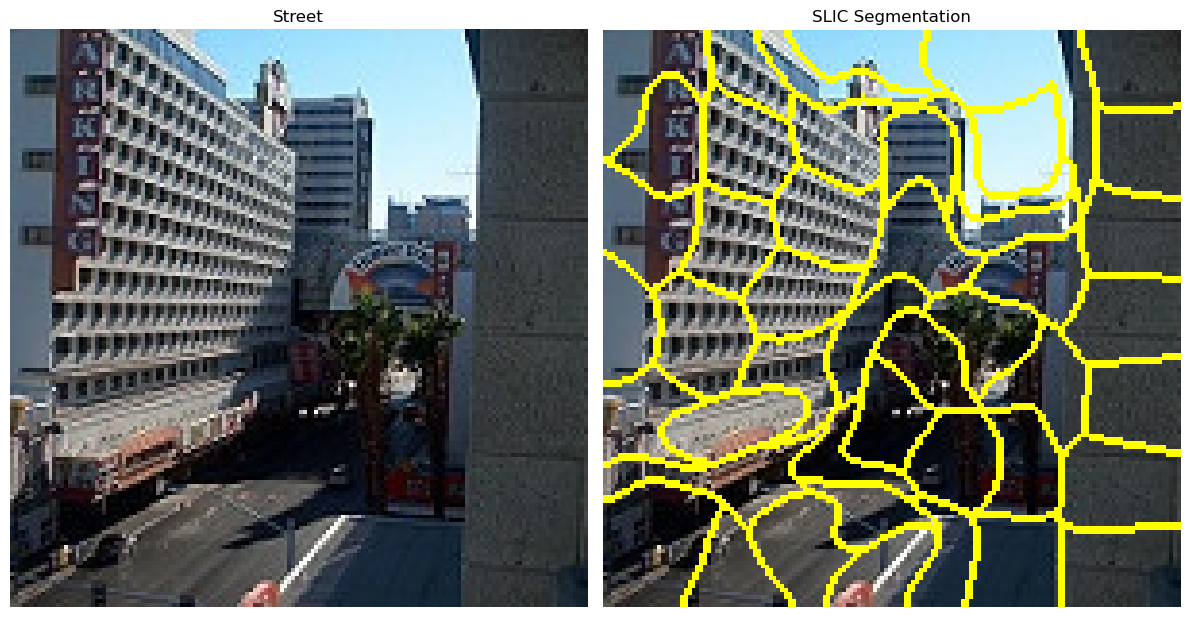

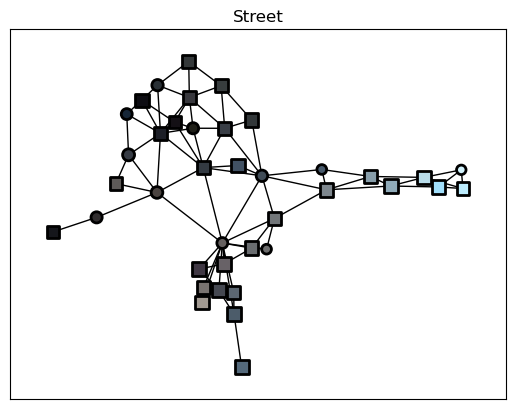

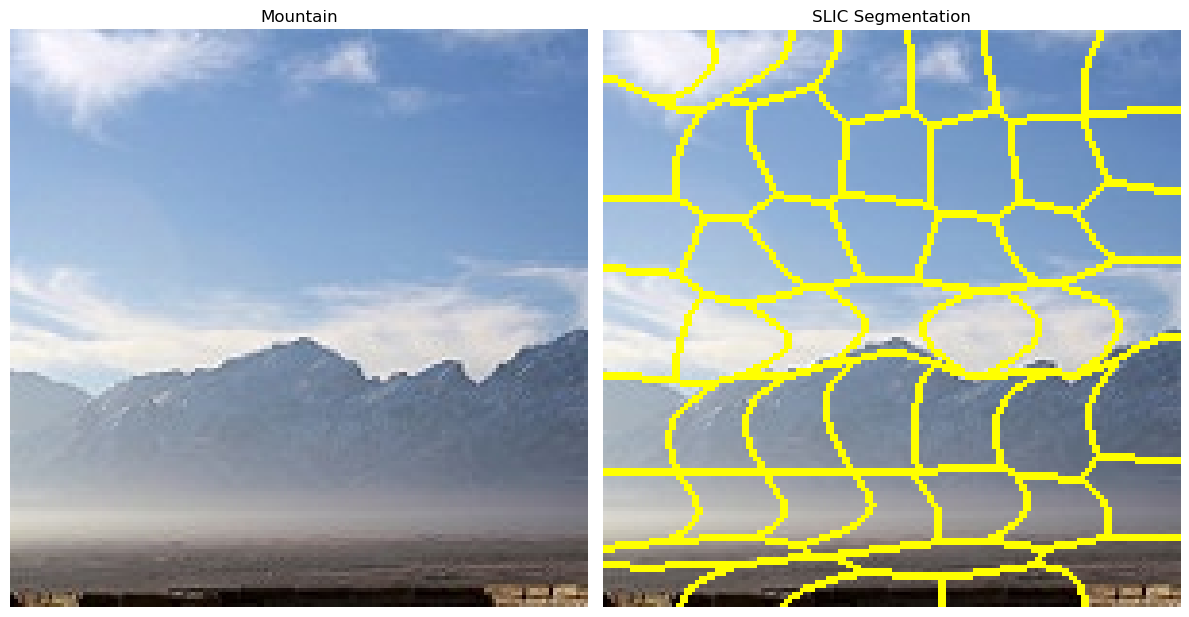

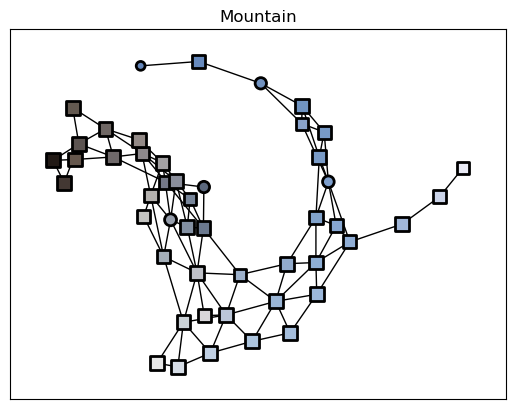

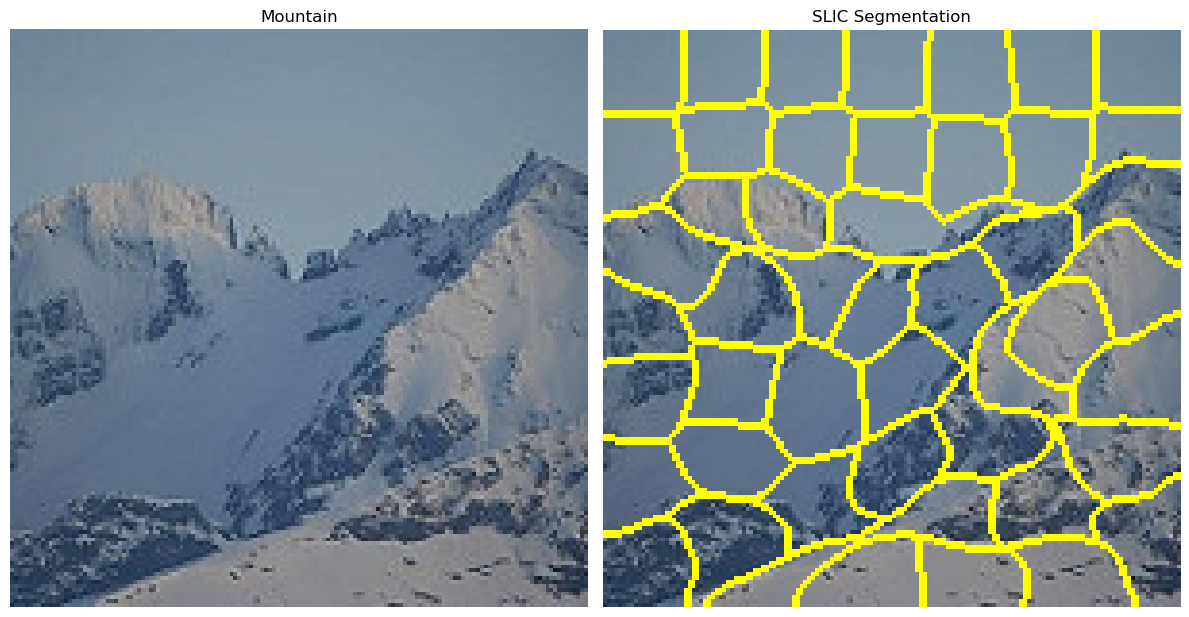

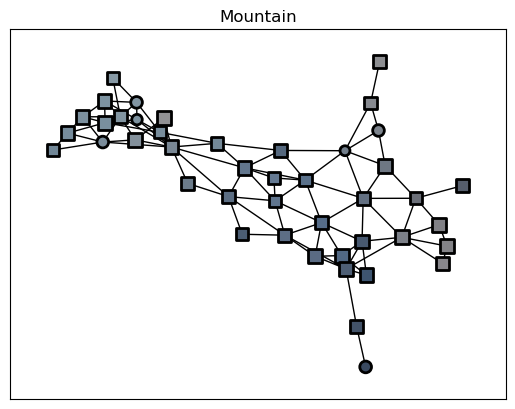

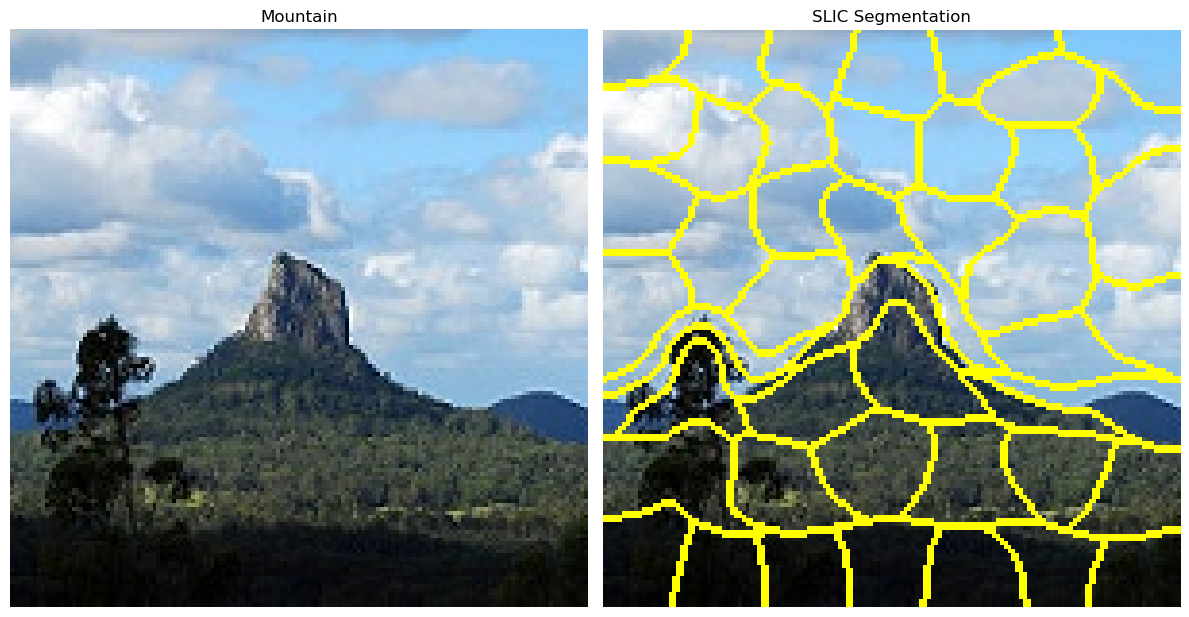

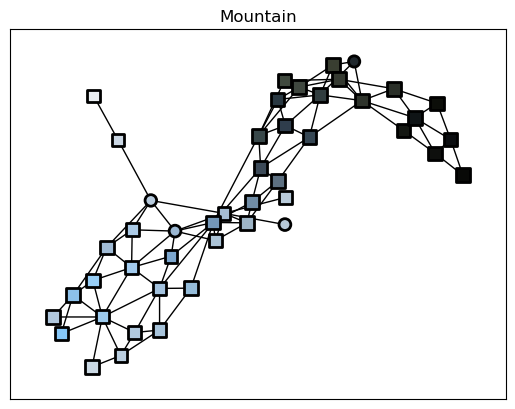

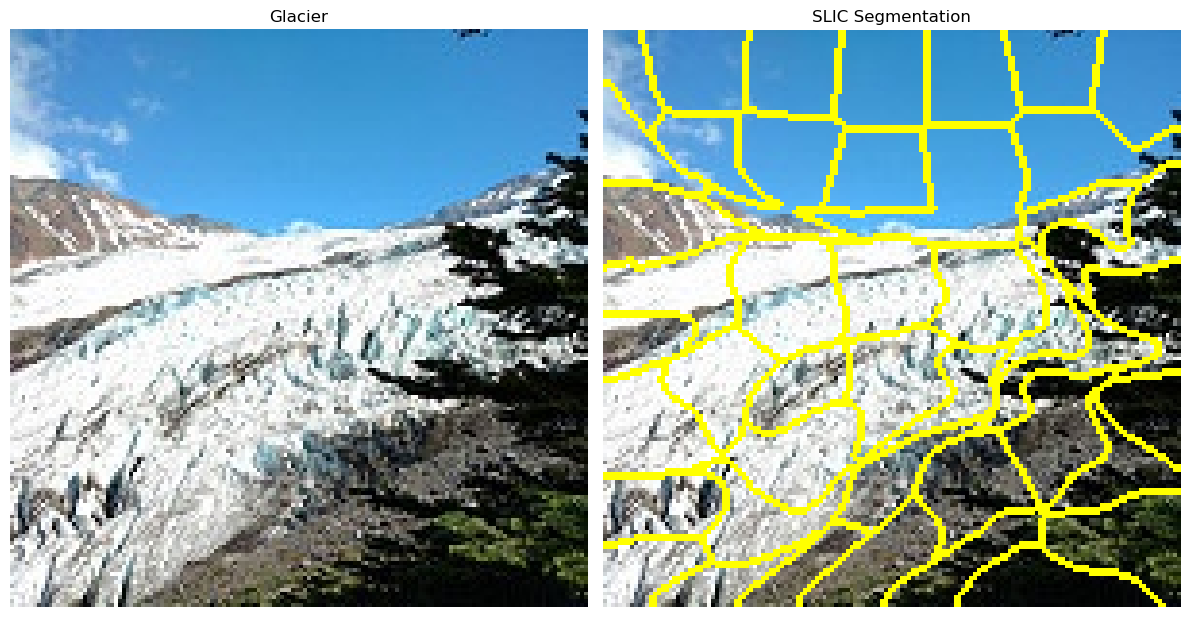

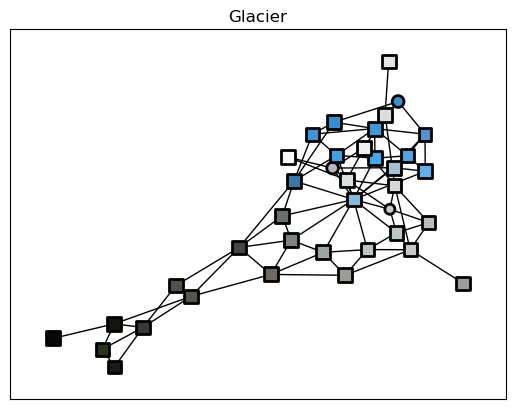

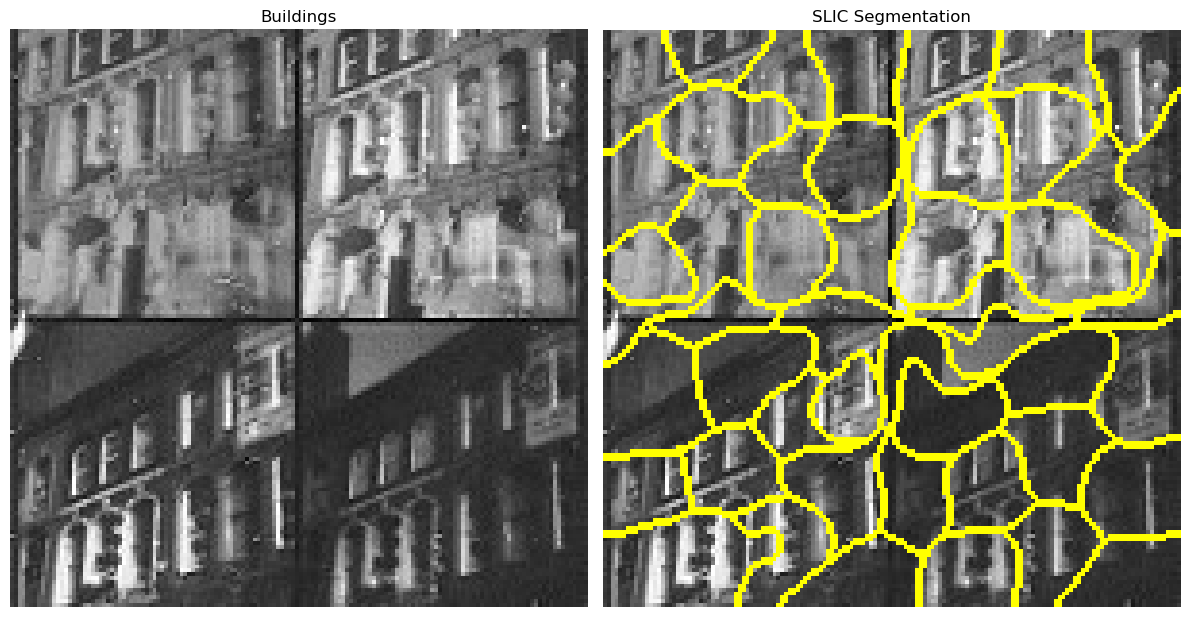

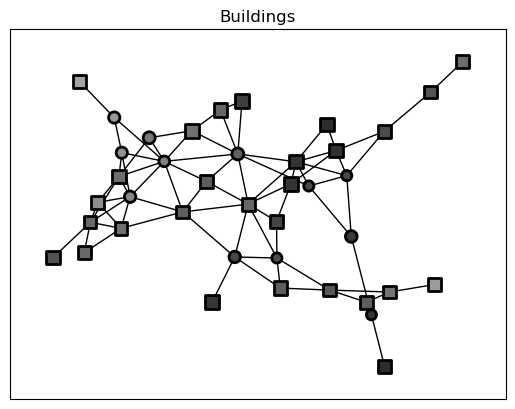

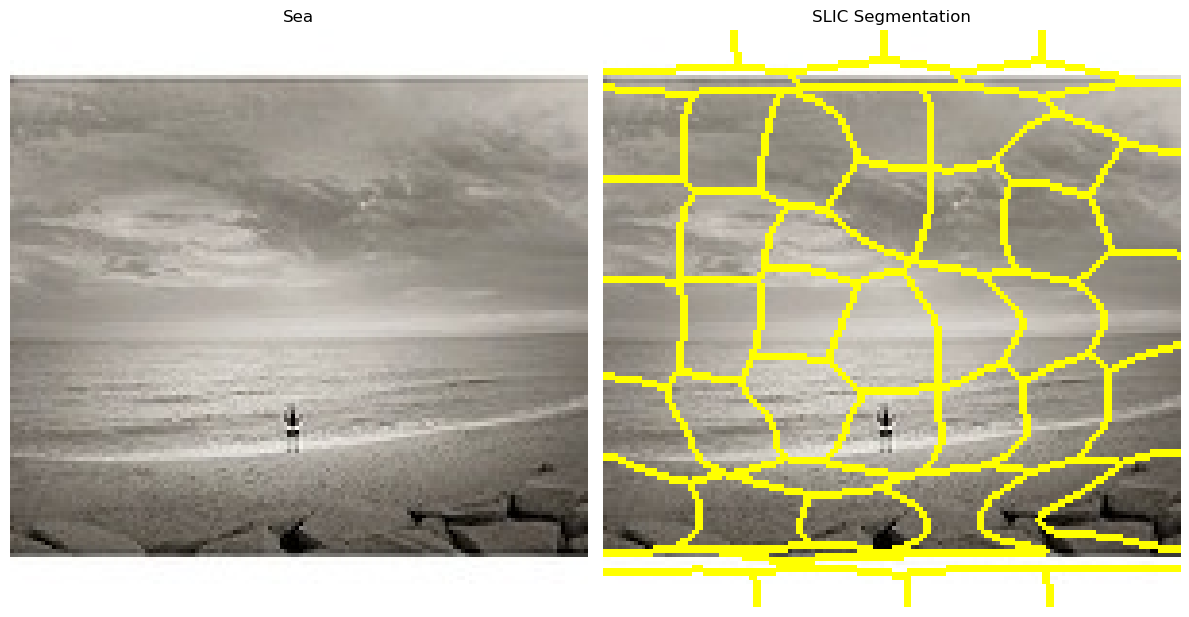

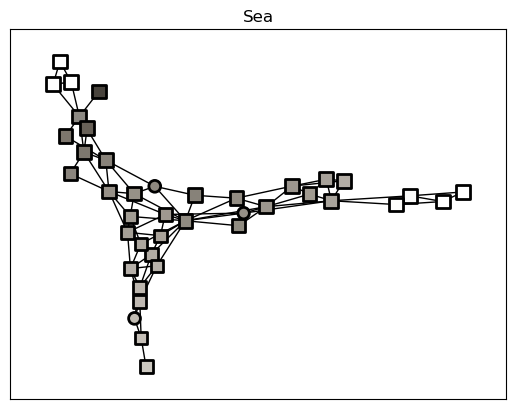

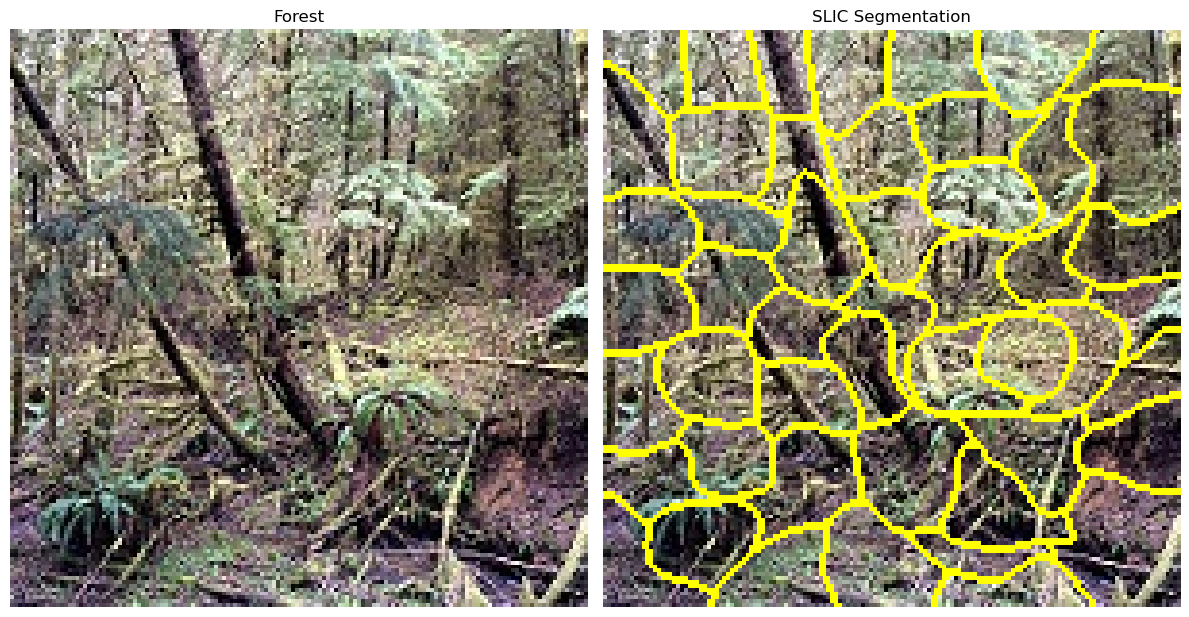

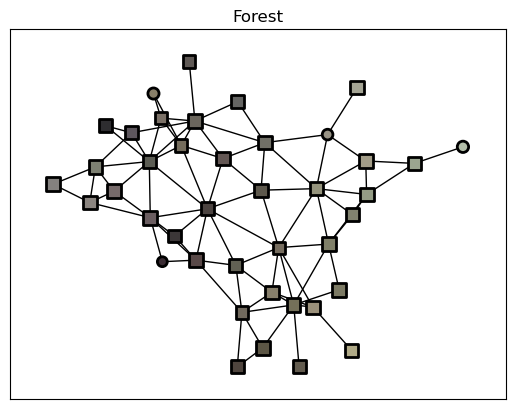

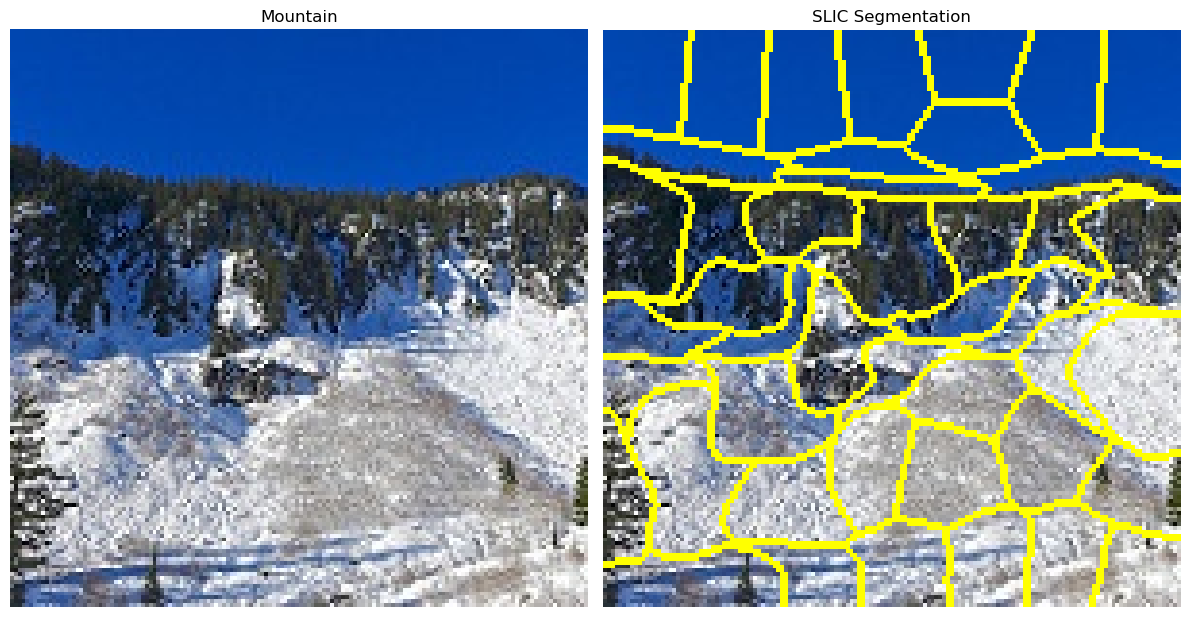

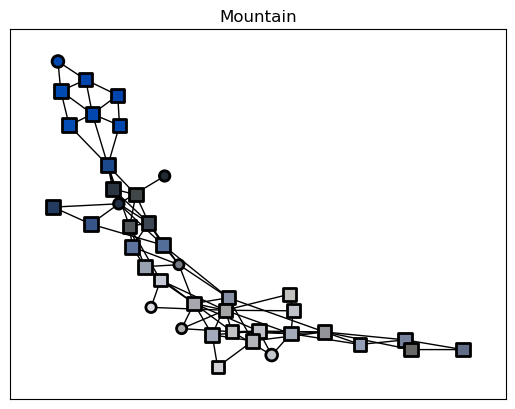

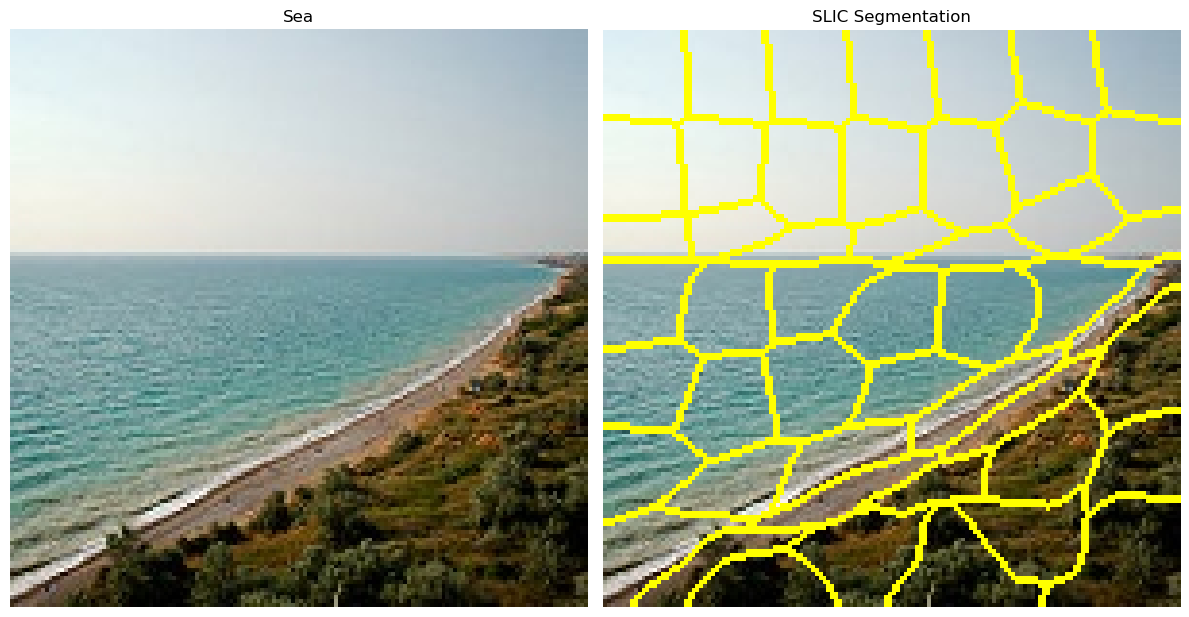

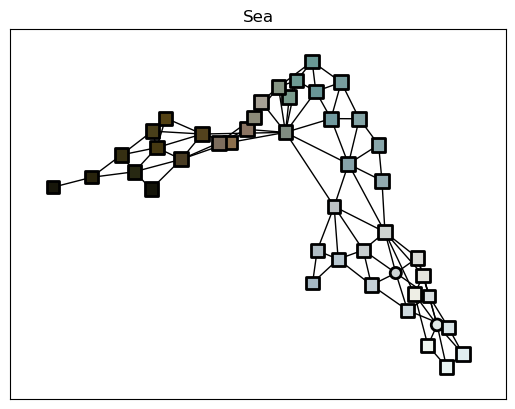

In [21]:
visualization_segments = 50

'''
Visualize the graphs using a small number of segments to describe the SLIC methodology
'''

def visualize_data():
    #Preprocess Dataset images
    training_data, training_labels = load_and_preprocess_images(training_folders)
    testing_data, testing_labels = load_and_preprocess_images(testing_folders)
    sample_size = 64
    view_size = 5 #Number of training and testing images shown
    training_indexes = random.sample(range(len(training_data)), min(sample_size, len(training_data)))
    testing_indexes = random.sample(range(len(testing_data)), min(sample_size, len(testing_data)))

    for i, x in enumerate(training_indexes):
        graph = make_graph_for_image_slic(training_data[x], visualization_segments)
        if i < view_size:
            segments = slic(training_data[x], n_segments=visualization_segments, sigma=sigma)
            show_comparison(training_data[x], training_labels[x], segments)
            draw_graph(graph, CLASSES[training_labels[x]])

    for i, x in enumerate(testing_indexes):
        graph = make_graph_for_image_slic(testing_data[x], visualization_segments)
        if i < view_size:
            segments = slic(testing_data[x], n_segments=visualization_segments, sigma=sigma)
            show_comparison(testing_data[x], testing_labels[x], segments)
            draw_graph(graph, CLASSES[testing_labels[x]])

visualize_data()

# Model

In [56]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_UNITS, output_dim=OUTPUT_SHAPE, dropout_rate=DROPOUT_RATE, NUM_HEADS=NUM_HEADS):
        super(GNN, self).__init__()
        self.gconv1 = GATConv(input_dim, hidden_dim, heads=NUM_HEADS)
        self.gconv2 = GATConv(hidden_dim*NUM_HEADS, hidden_dim, heads=NUM_HEADS)
        self.gconv3 = GraphConv(hidden_dim*NUM_HEADS, hidden_dim)
        self.gconv4 = SAGEConv(hidden_dim, hidden_dim)

        self.dropout = torch.nn.Dropout(p=dropout_rate)
        
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        #Pass the data through the Graph Conv Layers
        x = F.relu(self.gconv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.gconv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.gconv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.gconv4(x, edge_index))
        #Aggregate the output using global_mean_pool
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        #Apply Non-linearity with relu
        x = F.relu(self.fc1(x))
        #Pass to the output layer, grabbing the prediction logits.
        x = self.fc2(x)
        
        return x #return prediction logits

MODEL_NAME = "Model_1"

# Training

## Preprocess Data

In [57]:
# Load or preprocess data
try:
    # Load the preprocessed data stored in .pt files
    training_data = torch.load((CLEAN_DATA_FOLDER / 'processed_training_graphs.pt').resolve())
    testing_data = torch.load((CLEAN_DATA_FOLDER / 'processed_testing_graphs.pt').resolve())
    training_labels = np.load((CLEAN_DATA_FOLDER / 'training_labels.npy').resolve())
    testing_labels = np.load((CLEAN_DATA_FOLDER / 'testing_labels.npy').resolve())

except:
    # If the data hasn't been preprocessed, clean it, preprocess it, and save it
    print("data not found")
    clean_data()
    training_data = torch.load((CLEAN_DATA_FOLDER / 'processed_training_graphs.pt').resolve())
    testing_data = torch.load((CLEAN_DATA_FOLDER / 'processed_testing_graphs.pt').resolve())
    training_labels = np.load((CLEAN_DATA_FOLDER / 'training_labels.npy').resolve())
    testing_labels = np.load((CLEAN_DATA_FOLDER / 'testing_labels.npy').resolve())

#group the graphs and labels together for the DataLoader:
training_group = []
testing_group = []

for graph, data_label in zip(training_data, training_labels):
    #training
    data = convert_to_data(graph, data_label)
    training_group.append(data)

for graph, data_label in zip(testing_data, testing_labels):
    #testing
    data = convert_to_data(graph, data_label)
    testing_group.append(data)

#Load the data into training batches.
training_batches = DataLoader(training_group, batch_size=BATCH_SIZE, shuffle=True)
testing_batches = DataLoader(testing_group, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_25170/870105623.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_data = torch.load((CLEAN_DATA_FOLDER / 'processed_training_graphs.pt').resolve())

## Load Model

In [58]:
#DECLARE MODEL INSTANCE WITH INPUT DIMENSION
# Before the model call
Model_0 = GNN(input_dim=input_dim) # -3 color(R,G,B) + 1 Eccentricity + 1 Aspect_ratio + 1 solidity
Model_0.to(device)
#Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_0.parameters(), lr=LEARNING_RATE)

#Accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## Train

In [59]:
def train():
    '''
    Training Loop
    #1. Forward Pass
    #2. Calculate the loss on the model's predictions
    #3. Optimizer
    #4. Back Propagation using loss
    #5. Optimizer step
    '''

    # Lists to store loss values
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')  # Initialize best validation loss as infinity  
    epochs_no_improve = 0

    if LR_SCHEDULING:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    for epoch in range(EPOCHS):
        print(f"\nEpoch: {epoch}\n---------")
        if LR_SCHEDULING:
            print('lr: {0}'.format(optimizer.param_groups[0]['lr']))
        Model_0.train()
        training_loss = 0
        for batch_idx, batch_graphs in enumerate(training_batches):
            #Get the batch of features to send to the model
            batch_graphs = batch_graphs.to(device)
            x = batch_graphs.x
            #print(x)
            y = batch_graphs.y.to(device).long()  #Get the labels in y
            edge_index = batch_graphs.edge_index
            batch = batch_graphs.batch
            #1: Get predictions from the model
            y_pred = Model_0(x, edge_index, batch)

            #2: Calculate the loss on the model's predictions
            loss = loss_fn(y_pred, y) 
            training_loss += loss.item() #Keep track of each batch's loss

            #3: optimizer zero grad
            optimizer.zero_grad()

            #4: loss back prop
            loss.backward()

            #5: optimizer step:
            optimizer.step()
        #Finish training batch and calculate the average loss:
        training_loss /= len(training_batches)
        train_losses.append(training_loss)

        if LR_SCHEDULING:
            scheduler.step()

        #Move to testing on the testing data
        print("Testing the Model...")
        testing_loss, test_acc = 0, 0 #Metrics to test how well the model is doing
        Model_0.eval()
        with torch.inference_mode():
            for batch_idx, batch_graphs in enumerate(testing_batches):
                #Get the batch features to send to the model again
                batch_graphs = batch_graphs.to(device)
                x = batch_graphs.x
                y = batch_graphs.y.to(device).long()  #Get the labels in y
                edge_index = batch_graphs.edge_index
                batch = batch_graphs.batch
                #1: Model Prediction
                y_pred = Model_0(x, edge_index, batch)

                #2: Calculate loss
                loss = loss_fn(y_pred, y)
                testing_loss += loss.item()
                test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        testing_loss /= len(testing_batches)
        test_acc /= len(testing_batches)
        val_losses.append(testing_loss)
        print(f"Train loss: {training_loss:.4f} | Test loss: {testing_loss:.4f} | Test acc: {test_acc:.4f}%")

        # Check if current validation loss is the best so far
        if testing_loss < best_val_loss:
            best_val_loss = testing_loss
            # Save the model's parameters (state_dict) to a file
            torch.save(Model_0.state_dict(), (MODEL_FOLDER / (MODEL_NAME + '.pth')).resolve())
            print(f'Saved best model with validation loss: {best_val_loss:.4f}')
            epochs_no_improve = 0  # Reset counter if improvement
        else:
            if testing_loss > training_loss:
                epochs_no_improve += 1
                print(f'Num epochs since improvement: {epochs_no_improve}')
            else:
                print("Not the best, although model is not overfitting yet.")
            #stop training if overfitting starts to happen
            if epochs_no_improve >= PATIENCE:
                print("Early stopping")
                break

In [60]:
train()


Epoch: 0
---------
Testing the Model...
Train loss: 1.6243 | Test loss: 1.5788 | Test acc: 35.4167%
Saved best model with validation loss: 1.5788

Epoch: 1
---------
Testing the Model...
Train loss: 1.4494 | Test loss: 1.3730 | Test acc: 44.7806%
Saved best model with validation loss: 1.3730

Epoch: 2
---------
Testing the Model...
Train loss: 1.3906 | Test loss: 1.3279 | Test acc: 48.3821%
Saved best model with validation loss: 1.3279

Epoch: 3
---------
Testing the Model...
Train loss: 1.3489 | Test loss: 1.3522 | Test acc: 46.5426%
Num epochs since improvement: 1

Epoch: 4
---------
Testing the Model...
Train loss: 1.3206 | Test loss: 1.2682 | Test acc: 49.4792%
Saved best model with validation loss: 1.2682

Epoch: 5
---------
Testing the Model...
Train loss: 1.2916 | Test loss: 1.2460 | Test acc: 50.2327%
Saved best model with validation loss: 1.2460

Epoch: 6
---------
Testing the Model...
Train loss: 1.2726 | Test loss: 1.2493 | Test acc: 50.4322%
Not the best, although model is

## Results

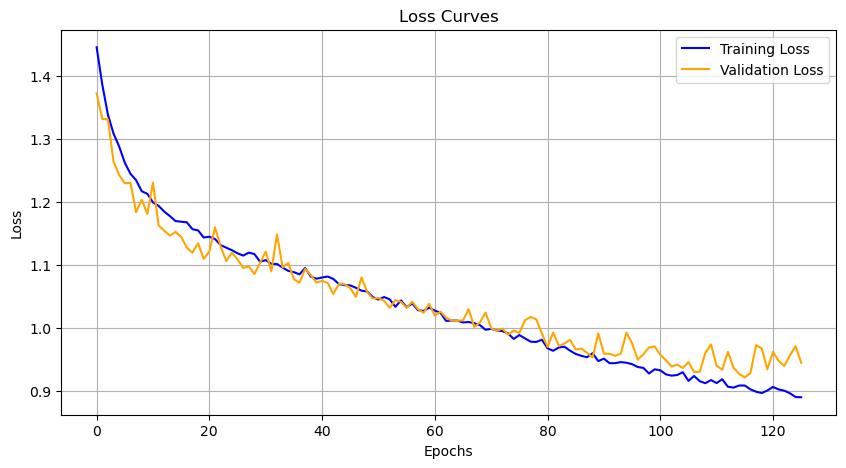

In [61]:
# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Predictions

In [62]:
amount = 10 #Number of images to run the model on (if doing the datasets pred data)
#Variable that decides whether to run the data on the datasets prediction data, or urls ('pred'/'url')
which = "pred" 
model = MODEL_NAME + '.pth'

Model_0 = GNN(input_dim=input_dim)
try:
    Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve()))
except:
    Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve(), map_location=torch.device('cpu')))
Model_0.to(device)

def model_on_prediction_data():
    #Run the model on the prediction folder data
    #preproccess the images then choose 'amount' randomly.
    num_correct = 0
    images = load_and_preprocess_pred_images(pred_folders)
    for x in range(amount):
        img_index = random.randint(0, len(images))
        img = images[img_index]
        segments = slic(img, n_segments=n_segments, sigma=sigma)
        show_comparison_no_label(img, segments)
        make_prediction(img)
        cor = input("Was I correct? (y/n): ")
        if cor == 'y':
            num_correct+=1
    
    print(f"Percentage correct: {num_correct/amount*100:2f}%")  

def model_on_new_images():
    #Take a given url, then download and preprocess it to run the model on
    while True:
        image_url = input("\nEnter image URL (q to quit): ")
        try:
            if image_url == 'q':
                break
            # Fetch the image from the URL
            response = requests.get(image_url)

            # Check if the request was successful
            if response.status_code == 200:
                # Open the image using Pillow and convert to RGB
                img = Image.open(BytesIO(response.content)).convert("RGB").resize(target_size)
                
                # Convert the image to a numpy array and normalize pixel values
                img_array = np.array(img, dtype=np.float32) / 255.0
                segments = slic(img_array, n_segments=n_segments, sigma=sigma)
                show_comparison_no_label(img_array, segments)
                make_prediction(img_array)

        except: 
            print("Invalid Image")

def make_prediction(img):
    #take given image, convert it into a graph
    img_graph = make_graph_for_image_slic(img)

    graph = from_networkx(img_graph)
    #Convert graph to data object
    data = convert_to_data(graph)
    data = data.to(device) #Send data to GPU if available
    print("Image converted to graph...")
    Model_0.eval()
    with torch.no_grad(): #Use the model's inference mode
        x = data.x
        edge_index = data.edge_index
        batch = torch.zeros(x.size(0), dtype=torch.long)  # All nodes belong to the same graph, so all batch indices are 0
        batch = batch.to(device)
        prediction = F.softmax(Model_0.forward(x, edge_index, batch), dim=1) #Model's prediction
        predicted_class = prediction.argmax(dim=1) #Class prediction extracted from prediction 
        #Draw and label the graph with the model's prediction
        graph_label = f"\nPredicted class: {CLASSES[predicted_class]}; Confidence: {prediction[0][predicted_class].item()*100:.2f}%"
        draw_graph(img_graph, graph_label)
        return predicted_class

/tmp/ipykernel_25170/3826319386.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve()))


/home/antlers/project/school/DataScienceProject/data_raw/seg_pred/seg_pred
Amount: 7301


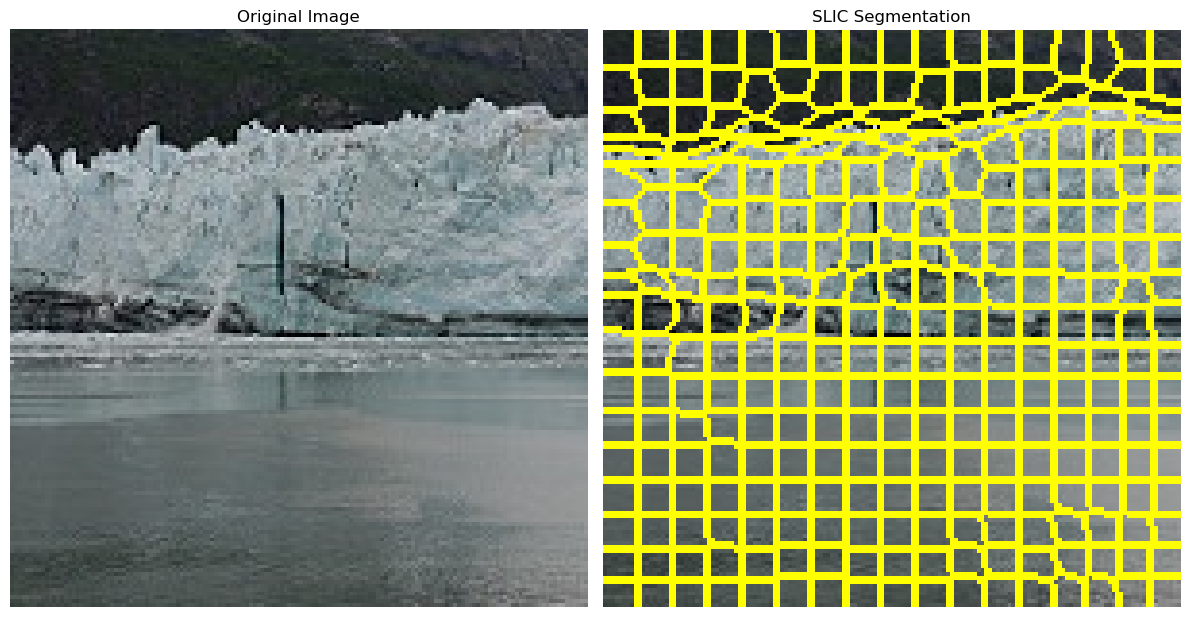

Image converted to graph...


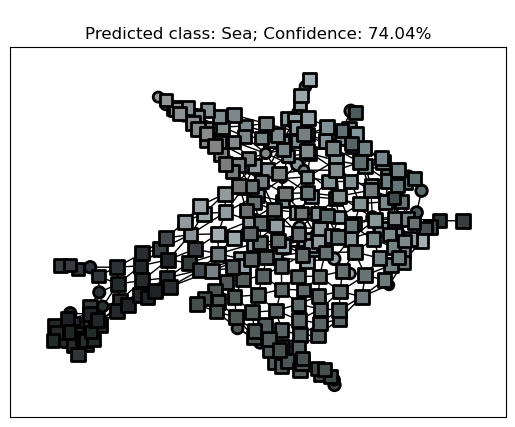

Was I correct? (y/n):  y


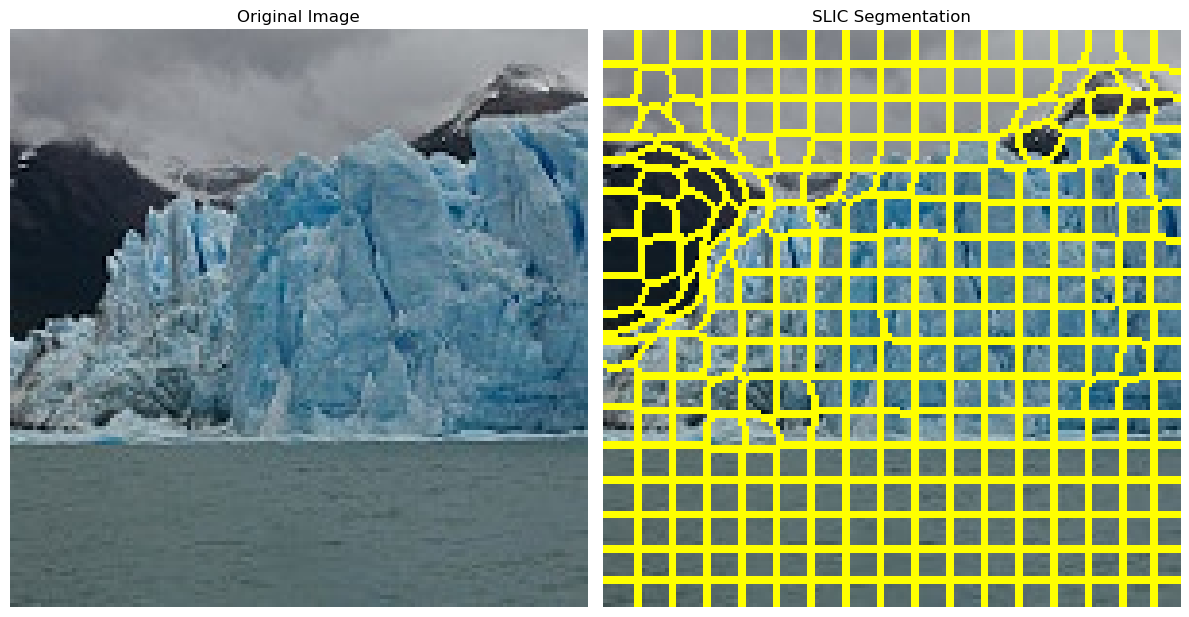

Image converted to graph...


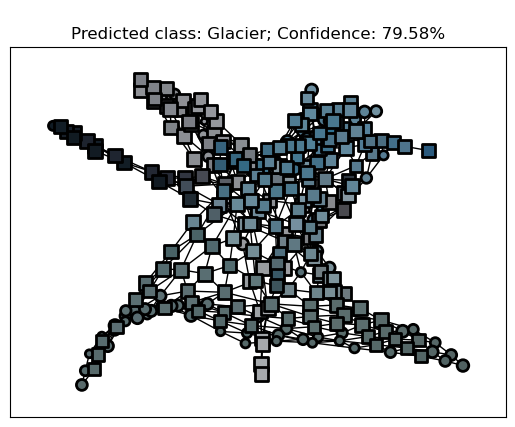

Was I correct? (y/n):  y


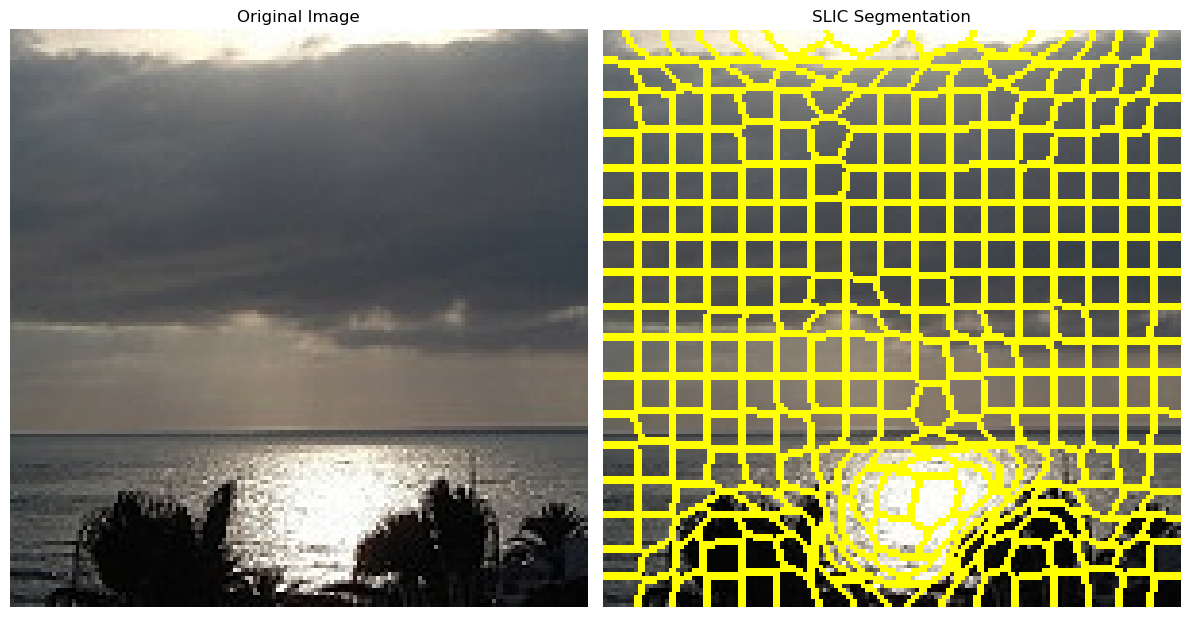

Image converted to graph...


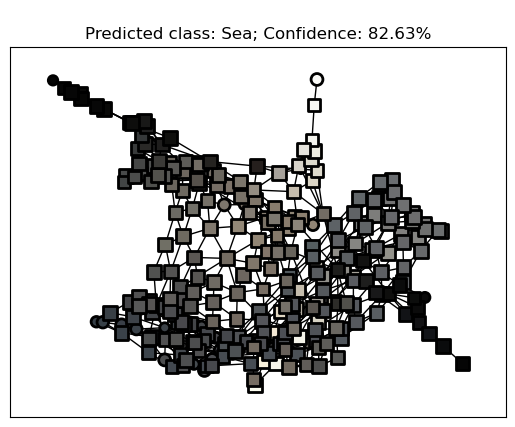

Was I correct? (y/n):  y


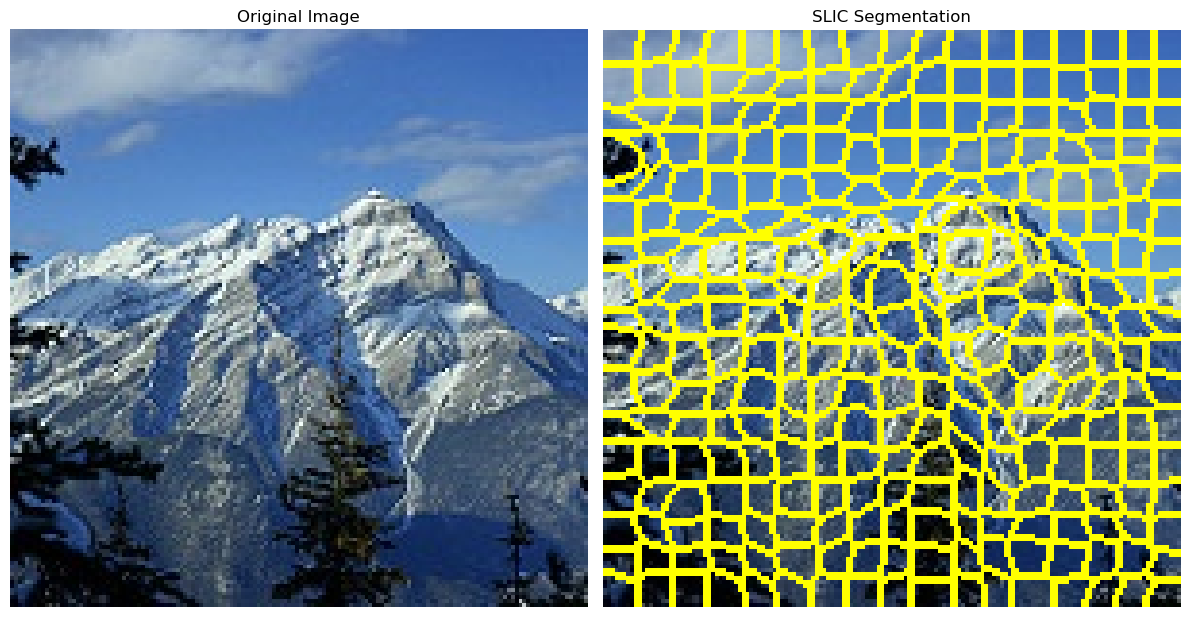

Image converted to graph...


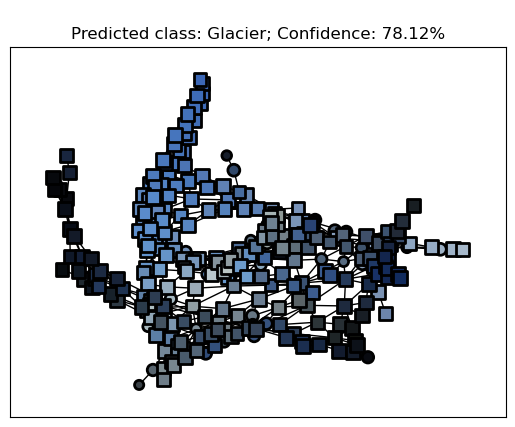

Was I correct? (y/n):  n


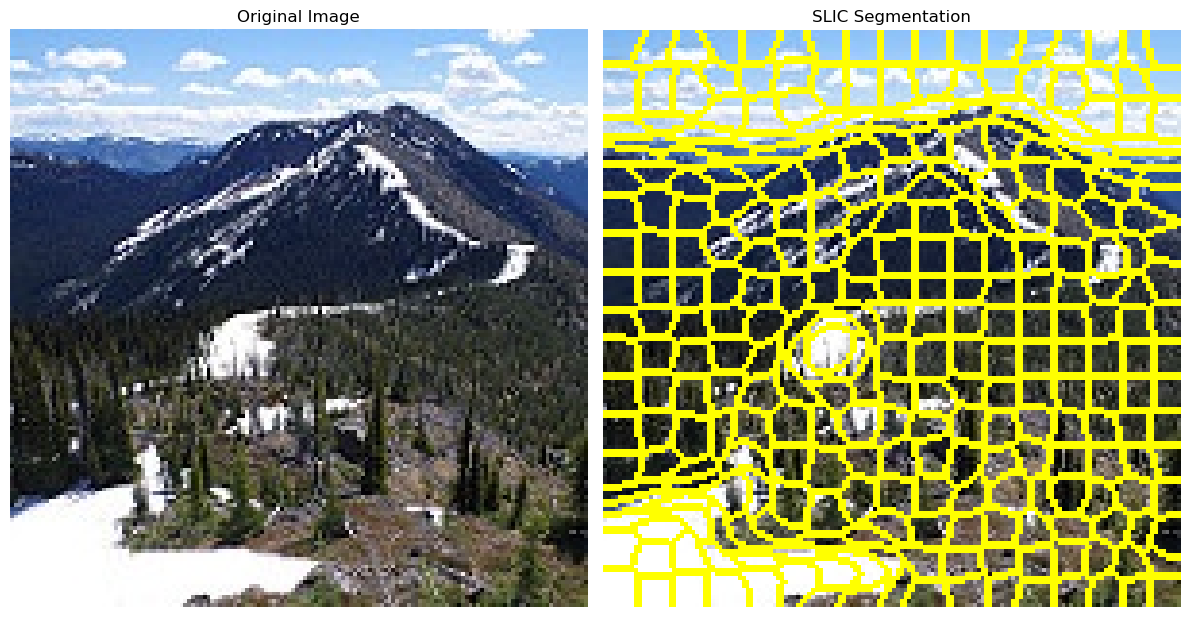

Image converted to graph...


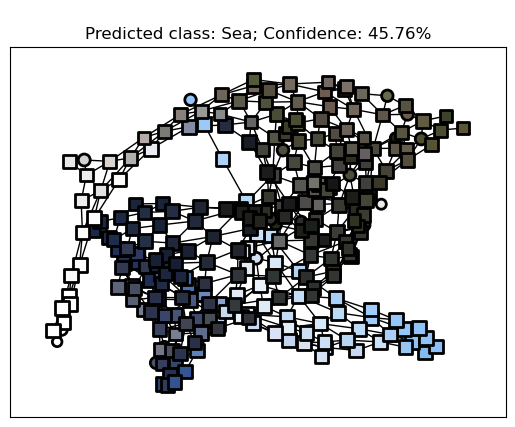

Was I correct? (y/n):  n


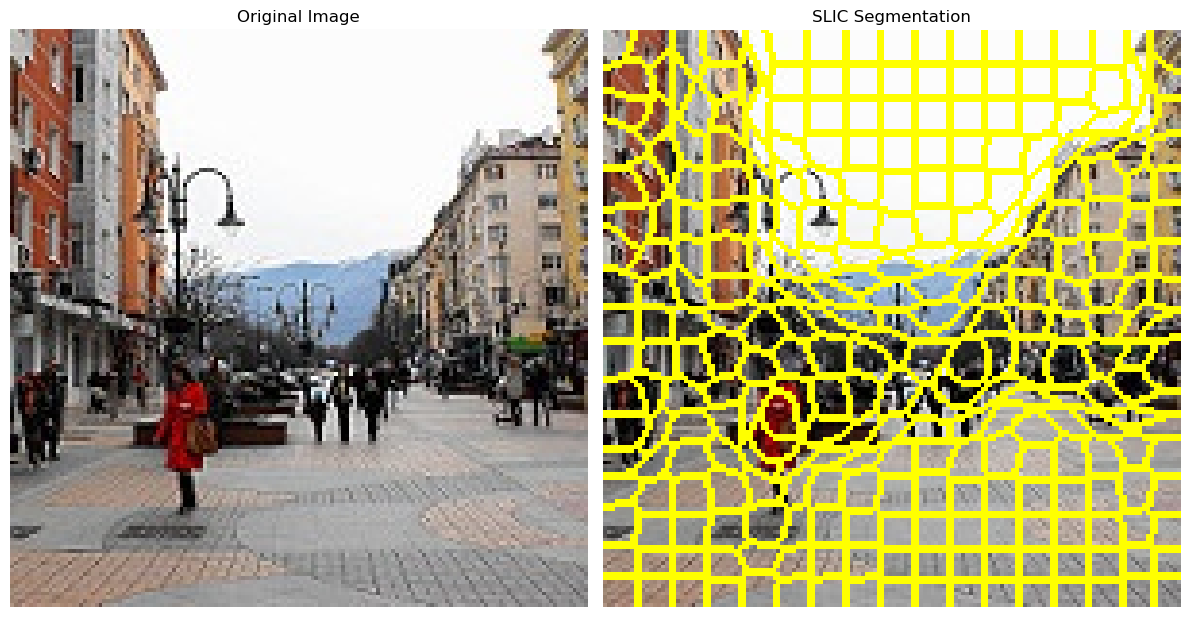

Image converted to graph...


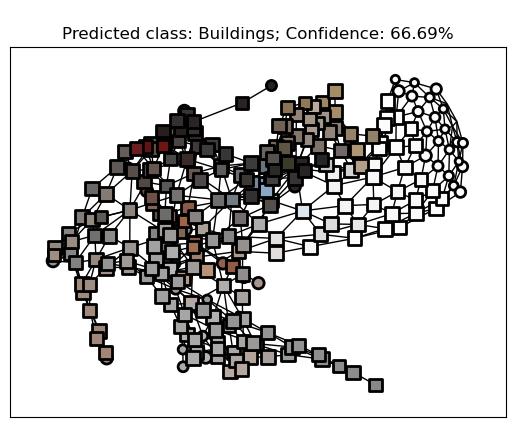

Was I correct? (y/n):  y


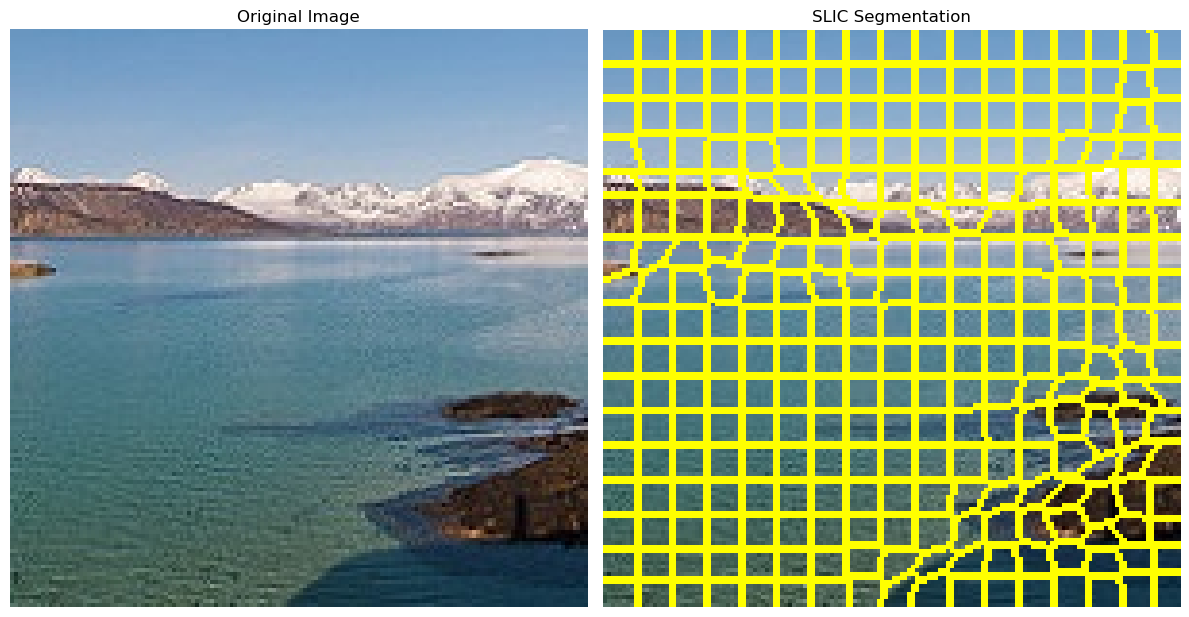

Image converted to graph...


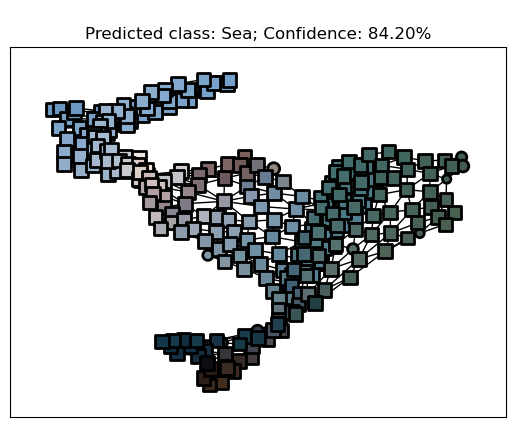

Was I correct? (y/n):  y


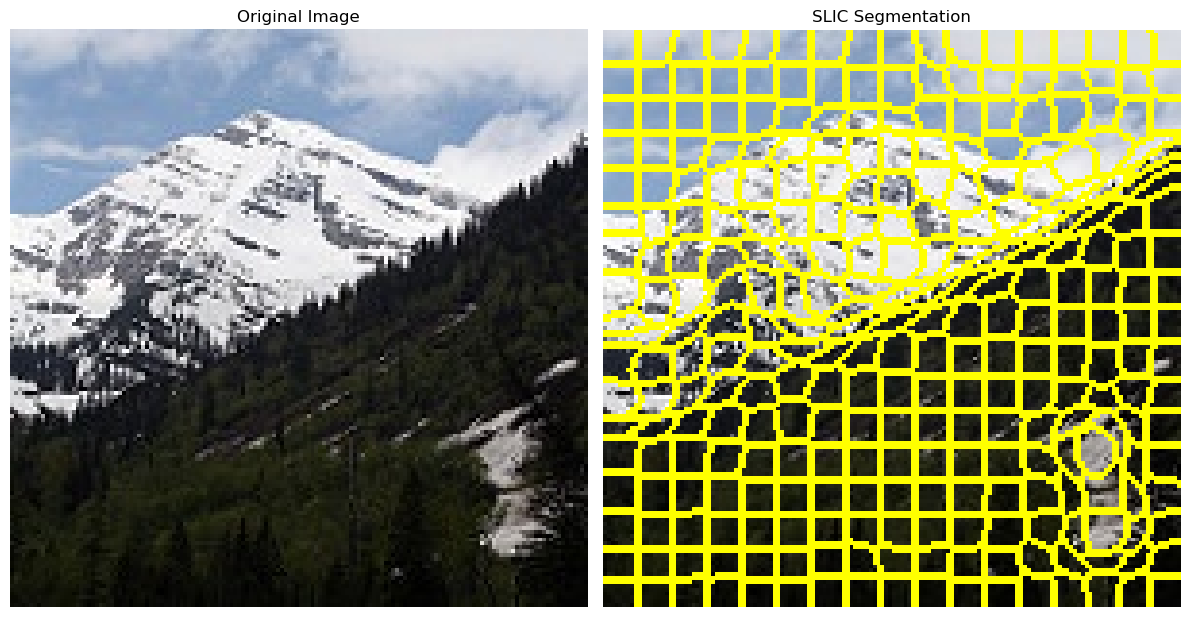

Image converted to graph...


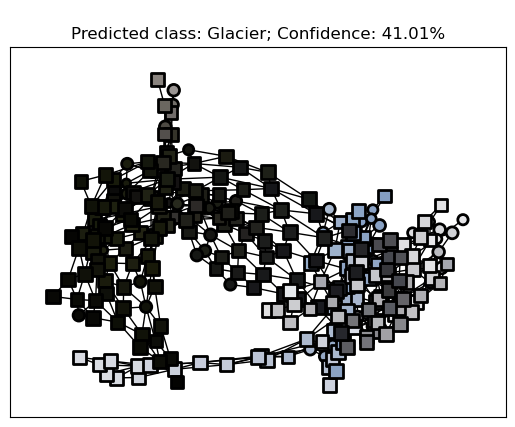

Was I correct? (y/n):  n


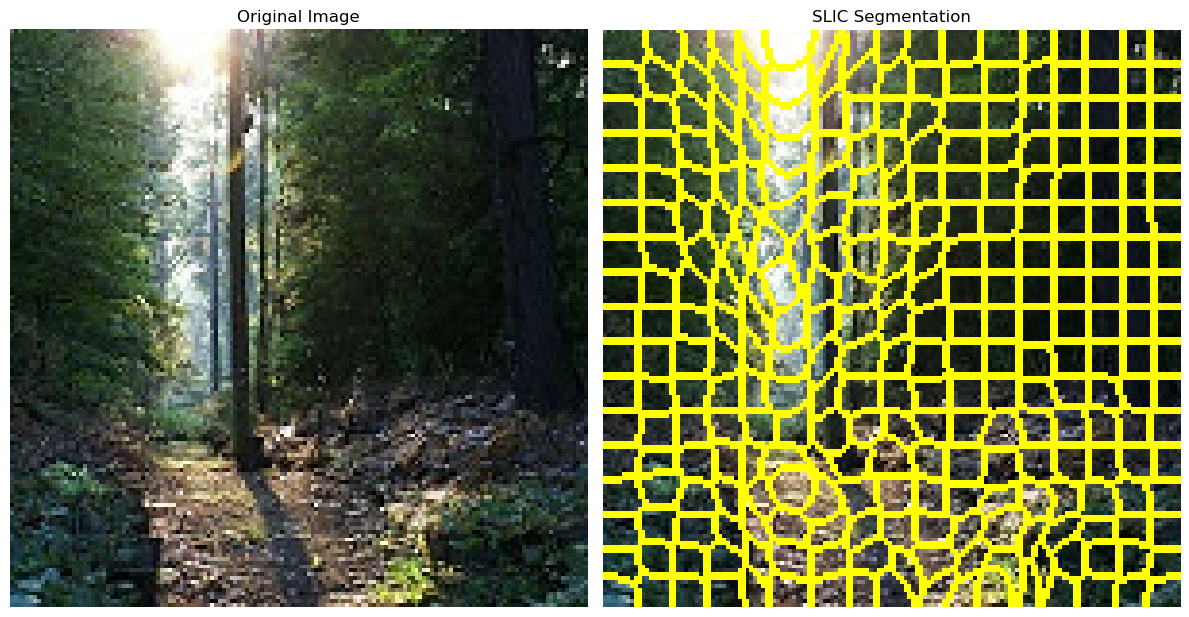

Image converted to graph...


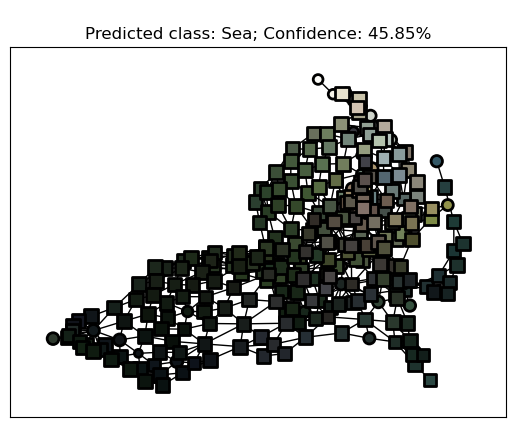

Was I correct? (y/n):  n


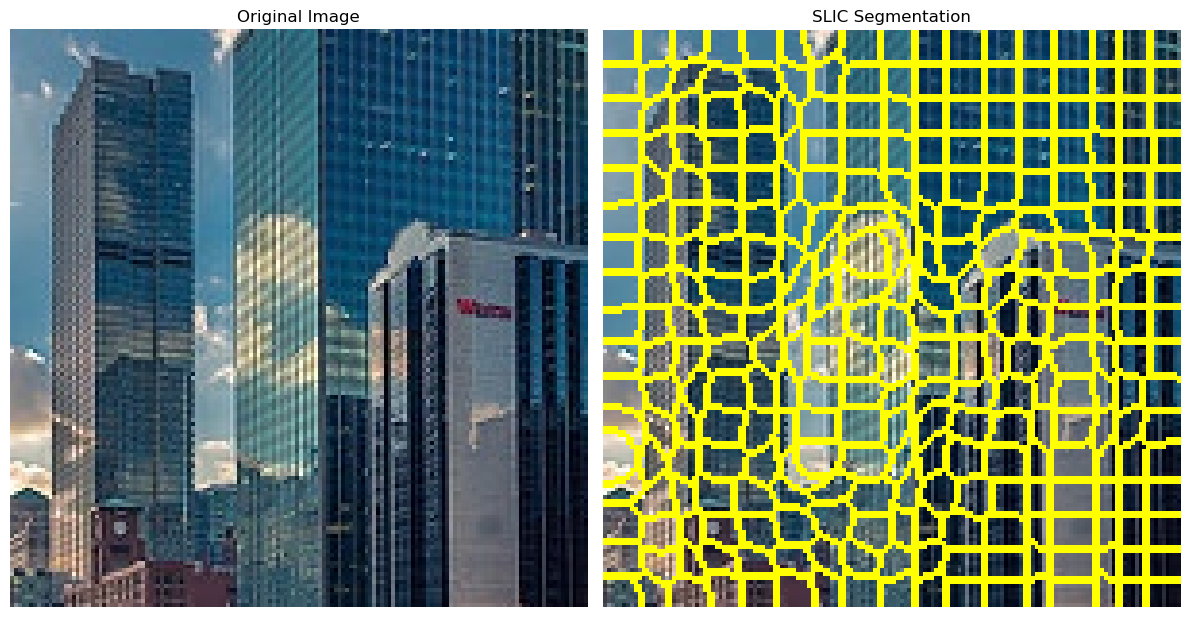

Image converted to graph...


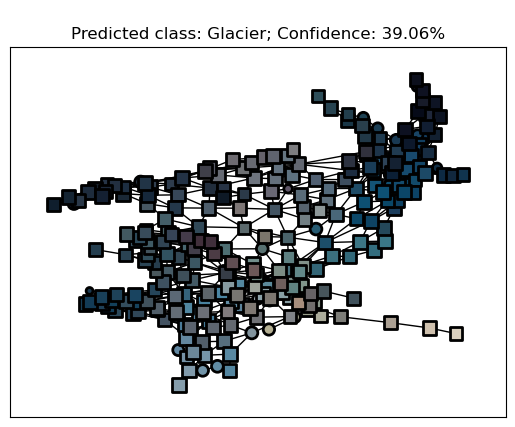

Was I correct? (y/n):  n


Percentage correct: 50.000000%


In [63]:
if which == 'pred':
    model_on_prediction_data()
else:
    model_on_new_images()

# Model 2

In [81]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_UNITS, output_dim=OUTPUT_SHAPE, dropout_rate=DROPOUT_RATE, NUM_HEADS=NUM_HEADS):
        super(GNN, self).__init__()
        self.gconv1 = GraphConv(input_dim, hidden_dim)
        self.gconv2 = GraphConv(hidden_dim, hidden_dim)
        self.gconv3 = GraphConv(hidden_dim, hidden_dim)
        self.gconv4 = GraphConv(hidden_dim, hidden_dim)

        self.bn = BatchNorm(40)
        
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        #Pass the data through the Graph Conv Layers
        x = F.relu(self.gconv1(x, edge_index))
        x = F.relu(self.gconv2(x, edge_index))
        x = F.relu(self.gconv3(x, edge_index))
        x = F.relu(self.gconv4(x, edge_index))
        x = self.bn(x)
        #Aggregate the output using global_mean_pool
        x = global_mean_pool(x, batch)
        #Apply Non-linearity with relu
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        #Pass to the output layer, grabbing the prediction logits.
        x = self.fc2(x)
        
        return x #return prediction logits

MODEL_NAME = "Model_H1"

## Load Model

In [82]:
#DECLARE MODEL INSTANCE WITH INPUT DIMENSION
# Before the model call
Model_0 = GNN(input_dim=input_dim) # -3 color(R,G,B) + 1 Eccentricity + 1 Aspect_ratio + 1 solidity
Model_0.to(device)
#Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model_0.parameters(), lr=LEARNING_RATE)

#Accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [83]:
train()


Epoch: 0
---------
Testing the Model...
Train loss: 1.6025 | Test loss: 1.4723 | Test acc: 40.3369%
Saved best model with validation loss: 1.4723

Epoch: 1
---------
Testing the Model...
Train loss: 1.3810 | Test loss: 1.4613 | Test acc: 40.9574%
Saved best model with validation loss: 1.4613

Epoch: 2
---------
Testing the Model...
Train loss: 1.3146 | Test loss: 1.4323 | Test acc: 42.5532%
Saved best model with validation loss: 1.4323

Epoch: 3
---------
Testing the Model...
Train loss: 1.2845 | Test loss: 1.7007 | Test acc: 42.0324%
Num epochs since improvement: 1

Epoch: 4
---------
Testing the Model...
Train loss: 1.2664 | Test loss: 1.2329 | Test acc: 53.4907%
Saved best model with validation loss: 1.2329

Epoch: 5
---------
Testing the Model...
Train loss: 1.2450 | Test loss: 1.2806 | Test acc: 48.7367%
Num epochs since improvement: 1

Epoch: 6
---------
Testing the Model...
Train loss: 1.2306 | Test loss: 1.3409 | Test acc: 46.7309%
Num epochs since improvement: 2

Epoch: 7
---

## Results

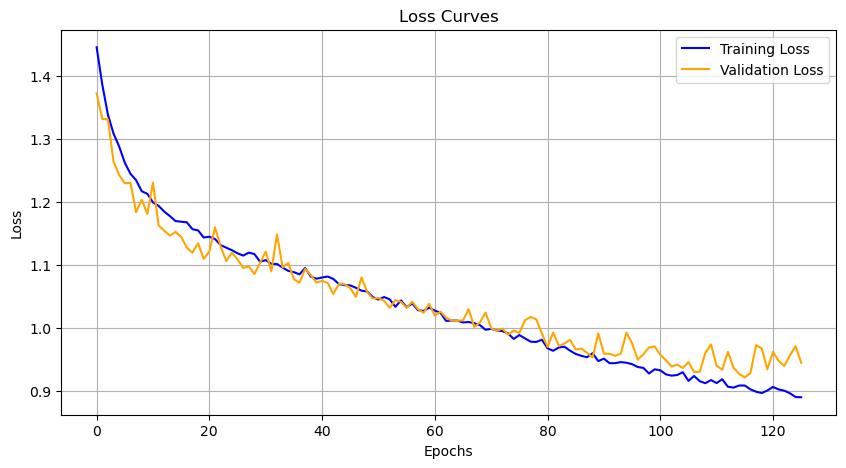

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Predictions

/tmp/ipykernel_25170/4115295662.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve()))


/home/antlers/project/school/DataScienceProject/data_raw/seg_pred/seg_pred
Amount: 7301


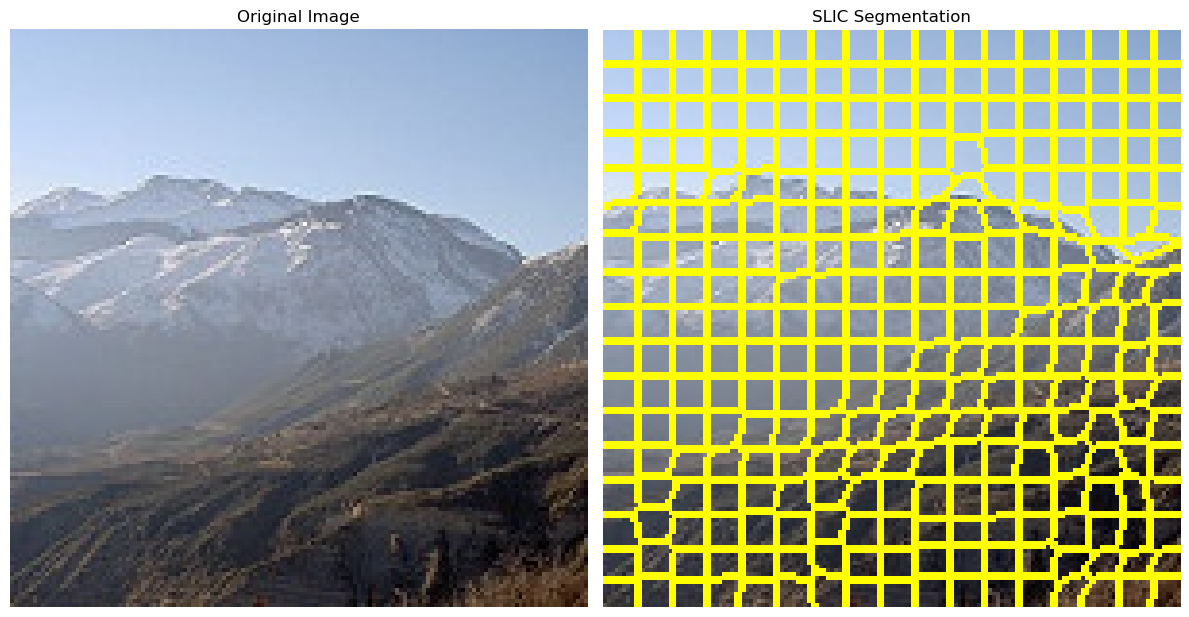

Image converted to graph...


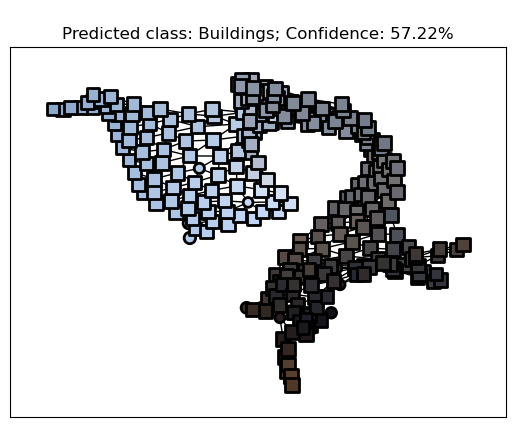

Was I correct? (y/n):  n


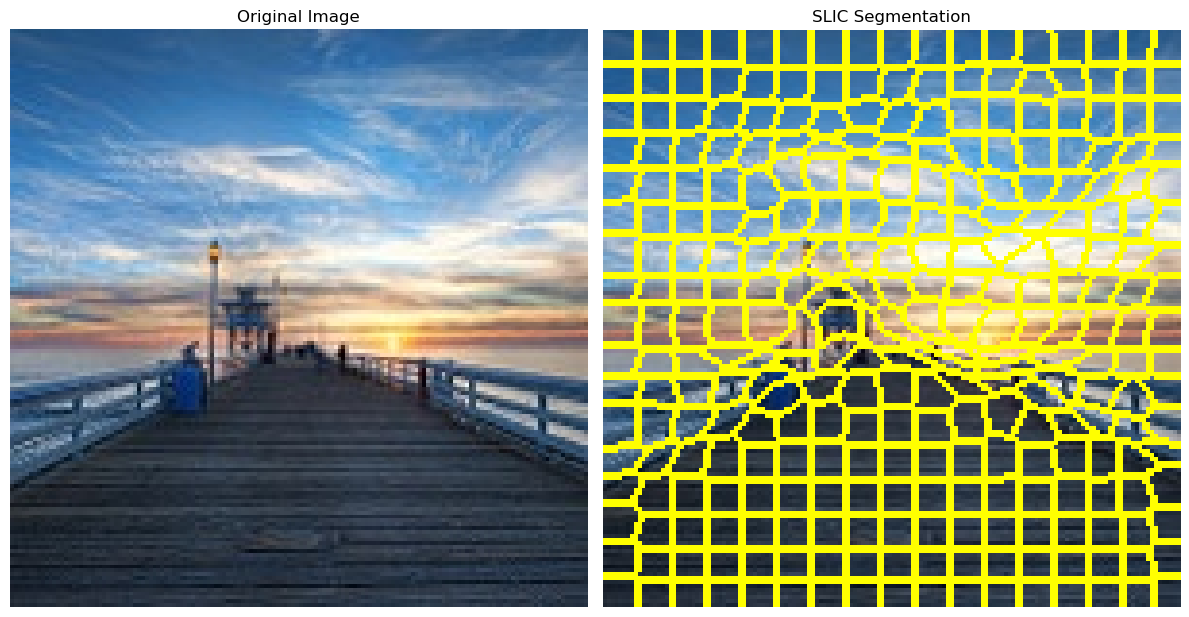

Image converted to graph...


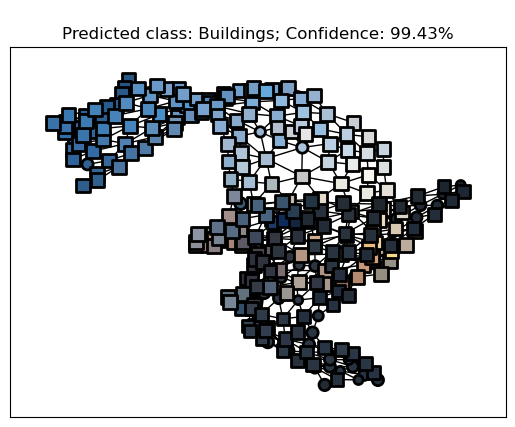

Was I correct? (y/n):  n


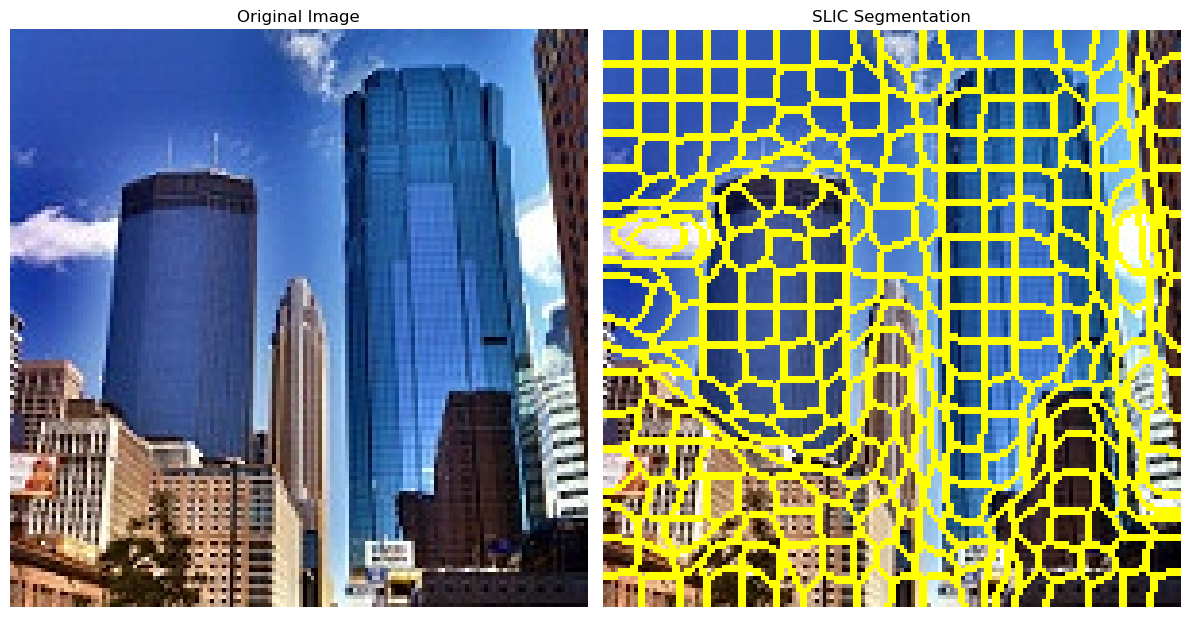

Image converted to graph...


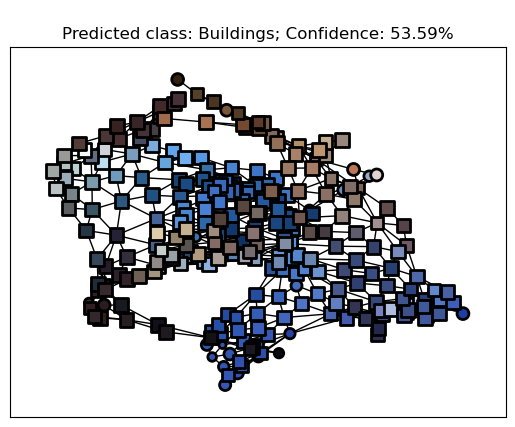

Was I correct? (y/n):  y


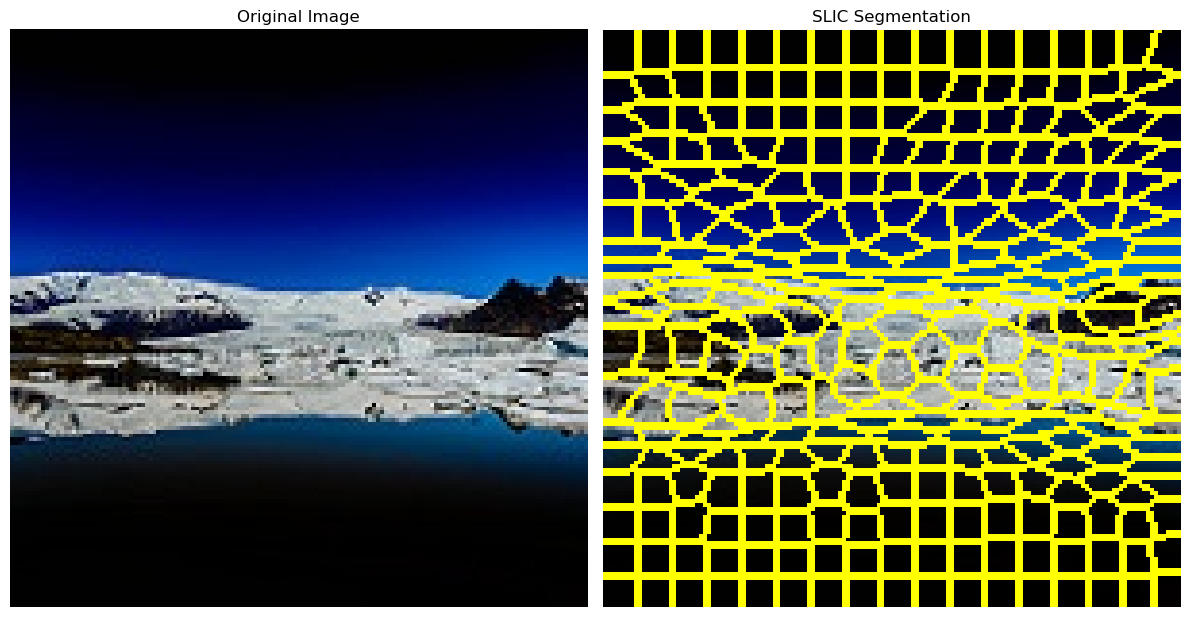

Image converted to graph...


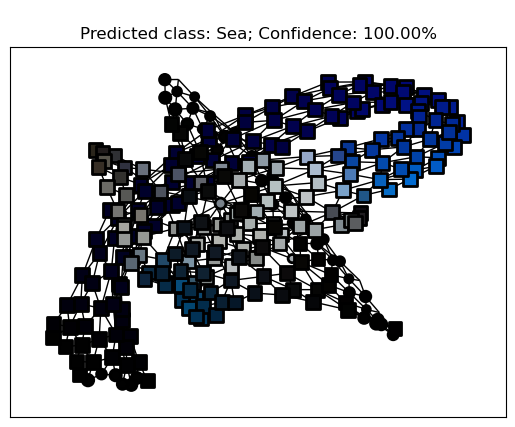

Was I correct? (y/n):  y


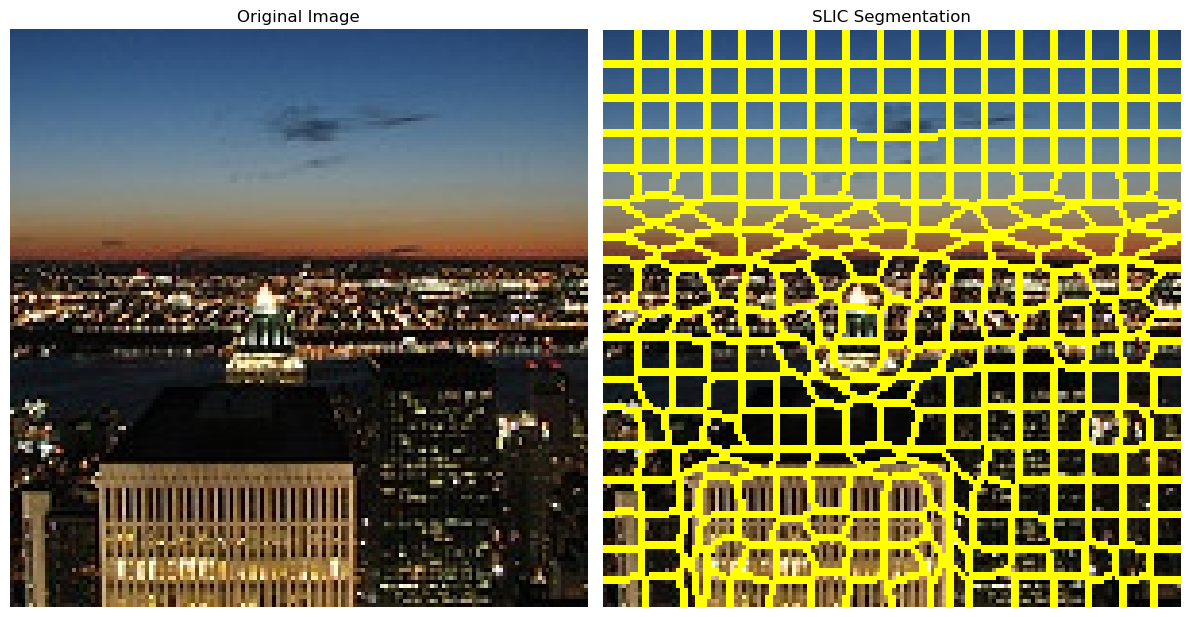

Image converted to graph...


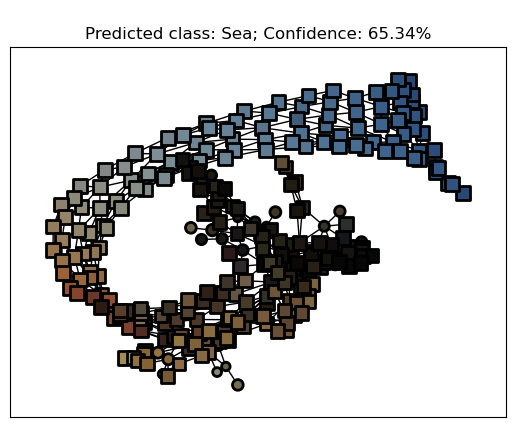

Was I correct? (y/n):  n


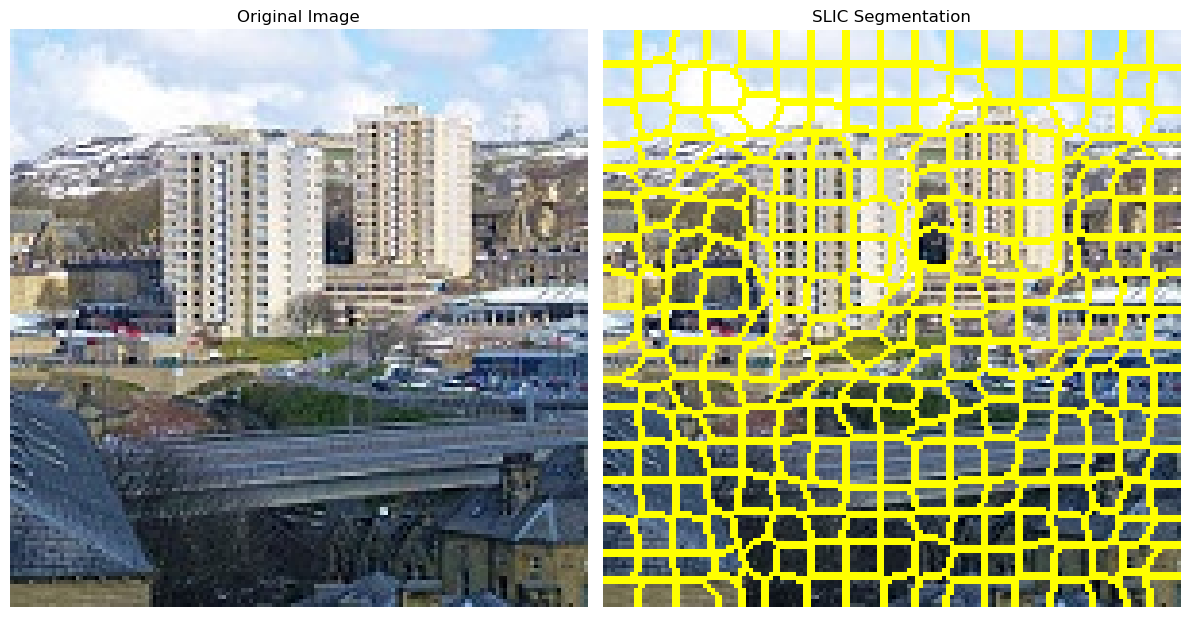

Image converted to graph...


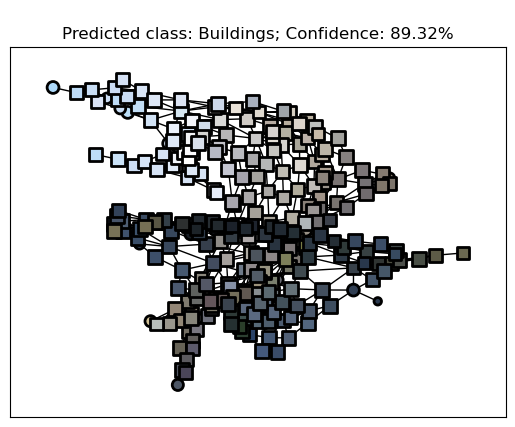

Was I correct? (y/n):  y


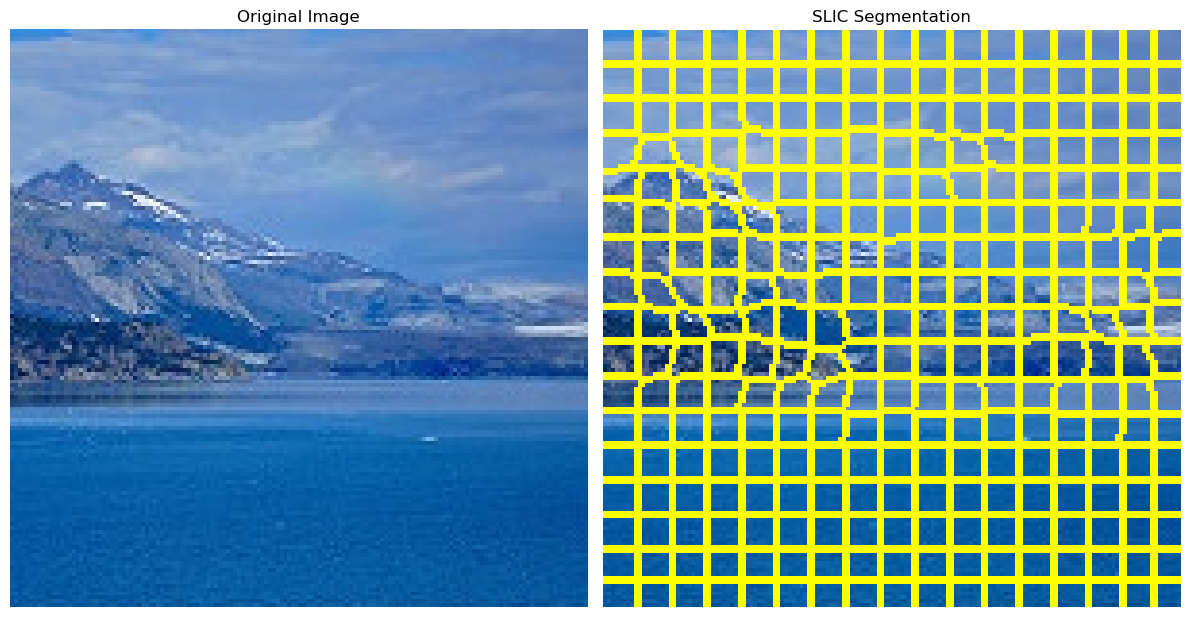

Image converted to graph...


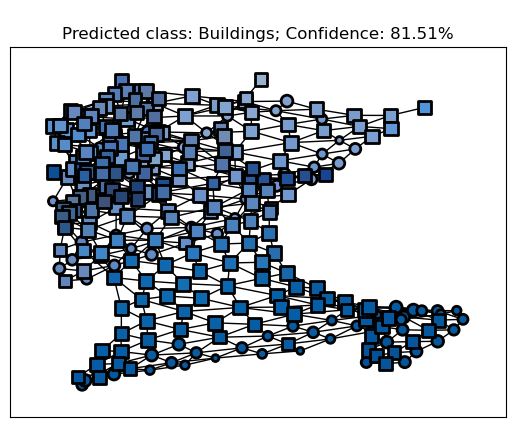

Was I correct? (y/n):  n


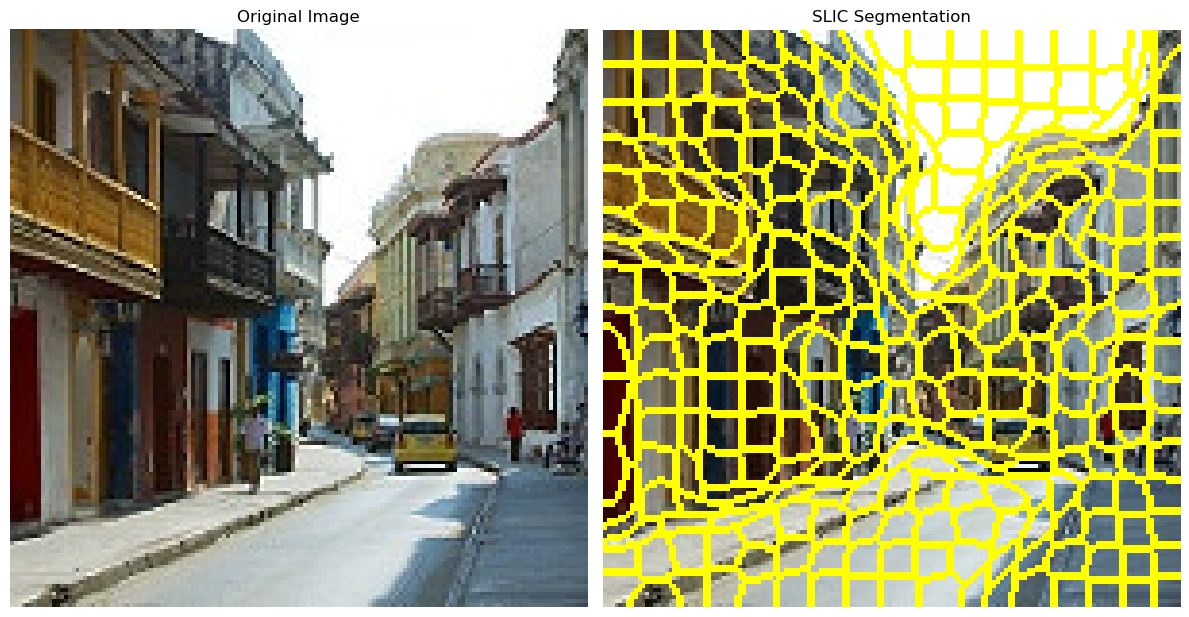

Image converted to graph...


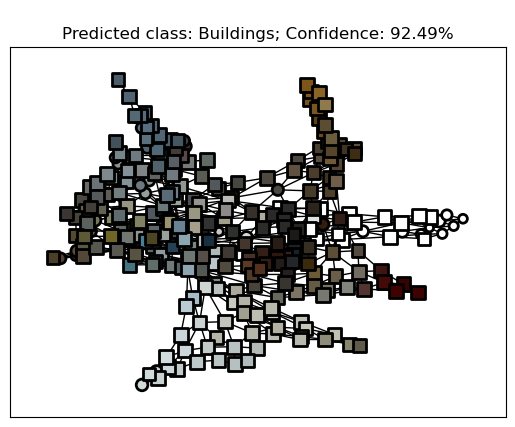

Was I correct? (y/n):  y


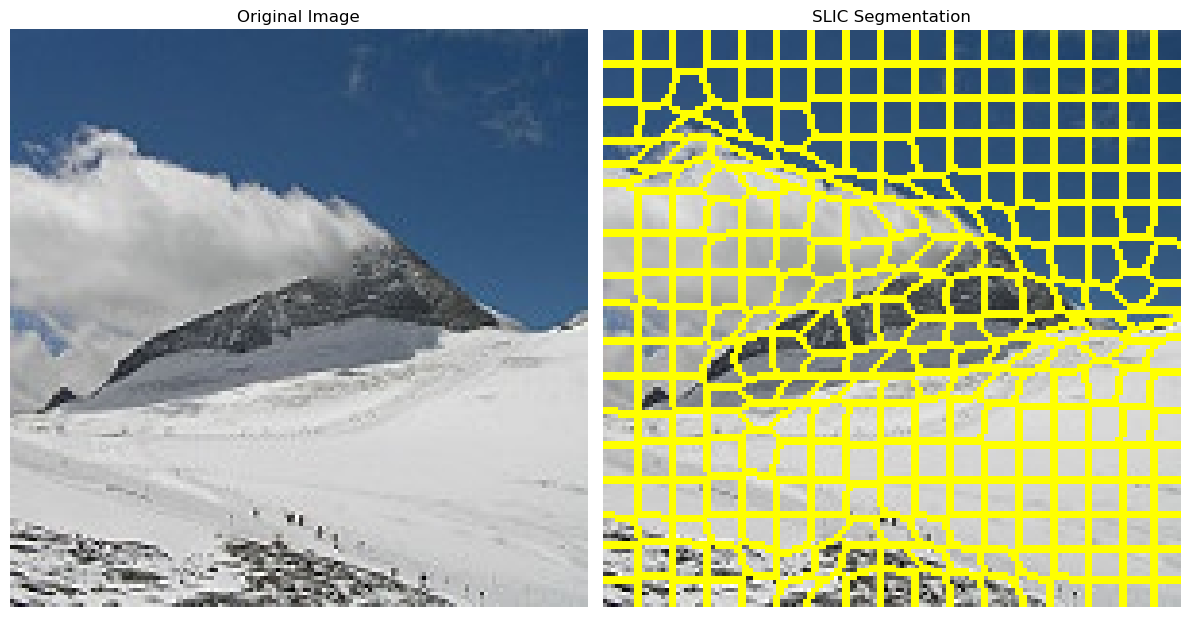

Image converted to graph...


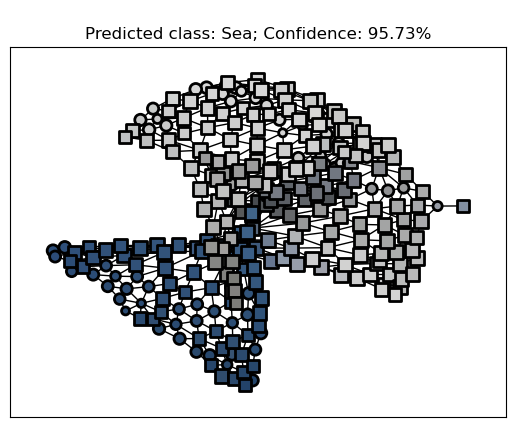

Was I correct? (y/n):  n


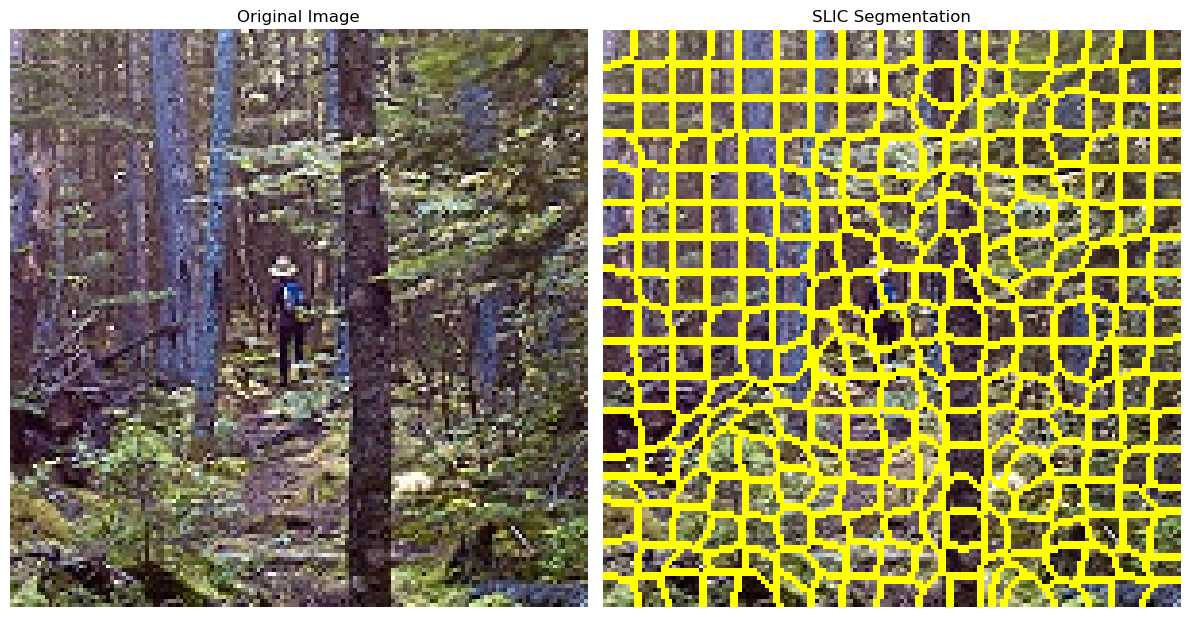

Image converted to graph...


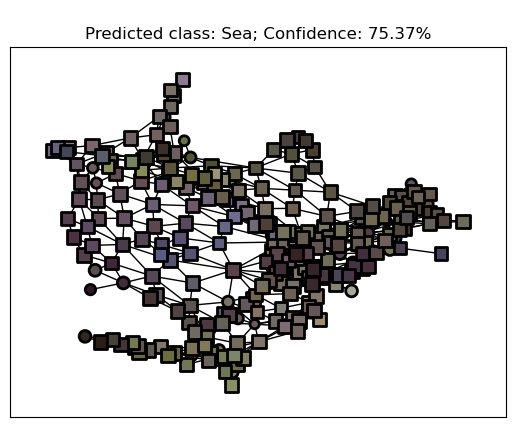

Was I correct? (y/n):  n


Percentage correct: 40.000000%


In [91]:
which = 'pred'
model = MODEL_NAME + '.pth'

Model_0 = GNN(input_dim=input_dim)
try:
    Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve()))
except:
    Model_0.load_state_dict(torch.load((MODEL_FOLDER / model).resolve(), map_location=torch.device('cpu')))
Model_0.to(device)

if which == 'pred':
    model_on_prediction_data()
else:
    model_on_new_images()